In [1]:
import sys
import os
import importlib
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
from sklearn.metrics import r2_score, mean_squared_error
base_path = "../src/"
sys.path.append(base_path)
import models
import train
from losses import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#datafilename='../../DATA/data_L25LH_TNG.hdf5'
datafilename='../../DATA/data_L50_TNG_v3.hdf5'
with h5py.File(datafilename, 'r') as f:
    print("Datasets available:")
    for key in f.keys():
        print(key)

with h5py.File(datafilename, 'r') as f:
    #Parameters = f['Parameters'][0, :1024].T.reshape(-1, 1)
    Parameters = f['Parameters'][:, :1024].T
logflag = np.array([False, False, True, True, True, True, False, False, False, True, True, False, False, True, False, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True])
logflag = logflag[:Parameters.shape[1]]
origParameters = Parameters
if not np.all(Parameters[:, logflag] > 0):
    raise ValueError("Some values to be logged are non-positive.")
PartiallyLoggedParameters = Parameters.copy()
PartiallyLoggedParameters[:, logflag] = np.log(PartiallyLoggedParameters[:, logflag])
means = PartiallyLoggedParameters.mean(axis=0)
stds = PartiallyLoggedParameters.std(axis=0)
Parameters = (PartiallyLoggedParameters - means) / stds

with h5py.File(datafilename, 'r') as f:
    Ms_Mh_s90 = f['Ms_Mh_s90'][:].T
    Ms_Mh_s61 = f['Ms_Mh_s61'][:].T
    MBH_Mh_s90 = f['MBH_Mh_s90'][:].T
    MBH_Mh_s61 = f['MBH_Mh_s61'][:].T
    Mg_Mh_s90 = f['Mg_Mh_s90'][:].T
    Mg_Mh_s61 = f['Mg_Mh_s61'][:].T
    Rs_Ms_s90 = f['Rs_Ms_s90'][:].T
    Rs_Ms_s61 = f['Rs_Ms_s61'][:].T
    SFR_Ms_s90 = f['SFR_Ms_s90'][:].T
    SFR_Ms_s61 = f['SFR_Ms_s61'][:].T
    Zs_Ms_s90 = f['Zs_Ms_s90'][:].T
    Zs_Ms_s61 = f['Zs_Ms_s61'][:].T
    SFRH_100Myr = f['SFRH_100Myr'][:].T

Datasets available:
MBH_Mh_s61
MBH_Mh_s90
Mg_Mh_s61
Mg_Mh_s90
Ms_Mh_s61
Ms_Mh_s90
Parameters
Rs_Ms_s61
Rs_Ms_s90
SFRH
SFRH_100Myr
SFRH_z
SFR_Ms_s61
SFR_Ms_s90
Zs_Ms_s61
Zs_Ms_s90
logMh_s61
logMh_s90
logMs_s61
logMs_s90


In [4]:
observable_block = {
    "Ms_Mh_s61" : torch.from_numpy(Ms_Mh_s61 ).float(),
    "Ms_Mh_s90" : torch.from_numpy(Ms_Mh_s90).float(),
    "MBH_Mh_s90": torch.from_numpy(MBH_Mh_s90).float(),
    "MBH_Mh_s61": torch.from_numpy(MBH_Mh_s61).float(),
    "Mg_Mh_s90": torch.from_numpy(Mg_Mh_s90 ).float(),
    "Mg_Mh_s61": torch.from_numpy(Mg_Mh_s61 ).float(),
    "Rs_Ms_s90": torch.from_numpy(Rs_Ms_s90 ).float(),
    "Rs_Ms_s61": torch.from_numpy(Rs_Ms_s61 ).float(),
    "SFR_Ms_s90": torch.from_numpy(SFR_Ms_s90).float(),
    "SFR_Ms_s61": torch.from_numpy(SFR_Ms_s61).float(),
    "Zs_Ms_s90": torch.from_numpy(Zs_Ms_s90 ).float(),
    "Zs_Ms_s61": torch.from_numpy(Zs_Ms_s61 ).float(),
    "SFRH_100Myr":torch.from_numpy(SFRH_100Myr).float(),
}

In [5]:
noise_cases = {
    "mbh_clean":{
        "MBH_Mh_s90": 0.0
    },
    "zs_clean":{
        "Zs_Ms_s90": 0.0
    },
    "mbh_noisy":{
        "MBH_Mh_s90": 20.0
    },
    "zs_noisy":{
        "Zs_Ms_s90": 20.0
    },
    "both_clean": {
        "Zs_Ms_s90": 0.0,
        "MBH_Mh_s90": 0.0
    },
    "mbh_noisy_zs_clean": {
        "Zs_Ms_s90": 0.0,
        "MBH_Mh_s90": 20.0
    },
    "mbh_clean_zs_noisy": {
        "Zs_Ms_s90": 20.0,
        "MBH_Mh_s90": 0.0
    },
    "both_noisy": {
        "Zs_Ms_s90": 20.0,
        "MBH_Mh_s90": 20.0
    }
}


In [6]:
for case in noise_cases.values(): 
    print(case.keys())

dict_keys(['MBH_Mh_s90'])
dict_keys(['Zs_Ms_s90'])
dict_keys(['MBH_Mh_s90'])
dict_keys(['Zs_Ms_s90'])
dict_keys(['Zs_Ms_s90', 'MBH_Mh_s90'])
dict_keys(['Zs_Ms_s90', 'MBH_Mh_s90'])
dict_keys(['Zs_Ms_s90', 'MBH_Mh_s90'])
dict_keys(['Zs_Ms_s90', 'MBH_Mh_s90'])


In [7]:
all_observables = set()
for case in noise_cases.values():
    all_observables.update(case.keys())

x_raw_dict = {key: observable_block[key].numpy() for key in all_observables}
#y_np = y.numpy()



In [8]:
print(all_observables)

{'MBH_Mh_s90', 'Zs_Ms_s90'}


In [9]:
def add_noise_and_normalize(array_np, noise_level=0.0):
    if noise_level > 0:
        std = np.std(array_np, axis=0)  # shape: (N_bins,)
        noise = np.random.normal(loc=0.0, scale=noise_level * std, size=array_np.shape)
        array_np = array_np + noise

    mean = np.mean(array_np, axis=0)
    std = np.std(array_np, axis=0)
    normalized = (array_np - mean) / std
    return normalized  

In [10]:
x_clean_concat = np.concatenate([add_noise_and_normalize(x_raw_dict[k], 0.0) for k in sorted(all_observables)], axis=1)
x_clean_tensor = torch.from_numpy(x_clean_concat).float()
y = torch.from_numpy(Parameters).float()

In [11]:
x_clean_tensor.shape

torch.Size([1024, 27])

In [12]:
# Hyperparameters
#input_dim    = x.shape[1]
output_dim   = y.shape[1]
hidden_dims  = [128, 64]
#hidden_dims  = [128, 64, 64]
#hidden_dims  = [64, 64]
lr           = 1e-4
wd           = 1e-5
dropout_rate = 0.2
epochs       = 2000
val_fraction = 0.1
batch_size   = 64
separate_models = False

In [13]:
n_val = int(len(x_clean_tensor) * val_fraction)
perm = torch.randperm(len(x_clean_tensor))
idx_train = perm[:-n_val]
idx_val = perm[-n_val:]

x_val, y_val = x_clean_tensor[idx_val], y[idx_val]
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=64, shuffle=False)

In [14]:
importlib.reload(train)
importlib.reload(models)

<module 'models' from '/Users/nicolasgarcia/Downloads/GAL_SBI/camelsPE/jupyter_notebook/../src/models.py'>

In [15]:
criterion = nn.MSELoss()

In [16]:
def make_train_loader_fn(selected_observables, x_raw_dict, y_vector, idx_train, batch_size):
    def loader_fn():
        x_list = []
        for key in sorted(selected_observables.keys()):
            noise_level = selected_observables[key]
            arr = x_raw_dict[key][idx_train]  # Subset training samples
            x_proc = add_noise_and_normalize(arr, noise_level)  # Add noise and normalize
            x_list.append(torch.from_numpy(x_proc).float())

        x_epoch = torch.cat(x_list, dim=1)
        y_epoch = y_vector[idx_train]

        return DataLoader(TensorDataset(x_epoch, y_epoch), batch_size=batch_size, shuffle=True)

    return loader_fn

In [17]:
def make_loader_fn(selected_observables, x_raw_dict, y_vector, idx, batch_size, noise_override=None):
    def loader_fn():
        x_list = []
        for key in sorted(selected_observables.keys()):
            arr = x_raw_dict[key][idx]
            noise_level = selected_observables[key] if noise_override is None else noise_override
            x_proc = add_noise_and_normalize(arr, noise_level)
            x_list.append(torch.from_numpy(x_proc).float())

        x_data = torch.cat(x_list, dim=1)
        y_data = y_vector[idx]
        return DataLoader(TensorDataset(x_data, y_data), batch_size=batch_size, shuffle=False)
    
    return loader_fn

In [18]:
all_results = []

for case_name, selected_observables in noise_cases.items():
    print(f"\Running test case: {case_name}")
    
    input_dim = sum(x_raw_dict[k].shape[1] for k in selected_observables)
    
    model = models.SimpleMLP(input_dim, hidden_dims, output_dim, dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.MSELoss()

    train_loader_fn = make_train_loader_fn(selected_observables, x_raw_dict, y, idx_train, batch_size)

    val_loader_fn = make_loader_fn(selected_observables, x_raw_dict, y, idx_val, batch_size)
    val_loader = val_loader_fn()

    train_losses, val_losses = train.fit_with_epoch_noise(
        model=model,
        train_loader=None,
        train_loader_fn=train_loader_fn,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        epochs=epochs
    )

    # Store results in memory
    all_results.append({
        "case_name": case_name,
        "selected_observables": selected_observables,
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses
    })


\Running test case: mbh_clean


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8972
[Iter 1000] validation loss: 0.9022
[Iter 1500] validation loss: 0.9097
[Iter 2000] validation loss: 0.9177
\Running test case: zs_clean


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9081
[Iter 1000] validation loss: 0.9055
[Iter 1500] validation loss: 0.9067
[Iter 2000] validation loss: 0.9072
\Running test case: mbh_noisy


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9824
[Iter 1000] validation loss: 0.9822
[Iter 1500] validation loss: 0.9824
[Iter 2000] validation loss: 0.9821
\Running test case: zs_noisy


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9812
[Iter 1000] validation loss: 0.9808
[Iter 1500] validation loss: 0.9810
[Iter 2000] validation loss: 0.9808
\Running test case: both_clean


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8477
[Iter 1000] validation loss: 0.8461
[Iter 1500] validation loss: 0.8461
[Iter 2000] validation loss: 0.8476
\Running test case: mbh_noisy_zs_clean


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9185
[Iter 1000] validation loss: 0.9115
[Iter 1500] validation loss: 0.9088
[Iter 2000] validation loss: 0.9088
\Running test case: mbh_clean_zs_noisy


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.8964
[Iter 1000] validation loss: 0.8973
[Iter 1500] validation loss: 0.9024
[Iter 2000] validation loss: 0.9070
\Running test case: both_noisy


Training:   0%|          | 0/2000 [00:00<?, ?iter/s]

[Iter  500] validation loss: 0.9819
[Iter 1000] validation loss: 0.9818
[Iter 1500] validation loss: 0.9818
[Iter 2000] validation loss: 0.9817


 Case: mbh_clean


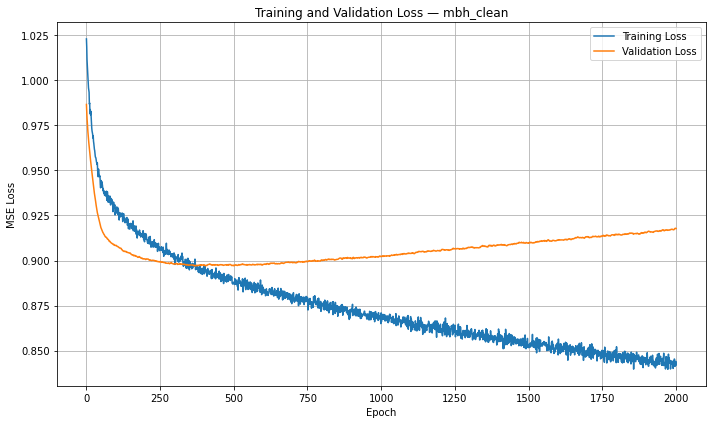

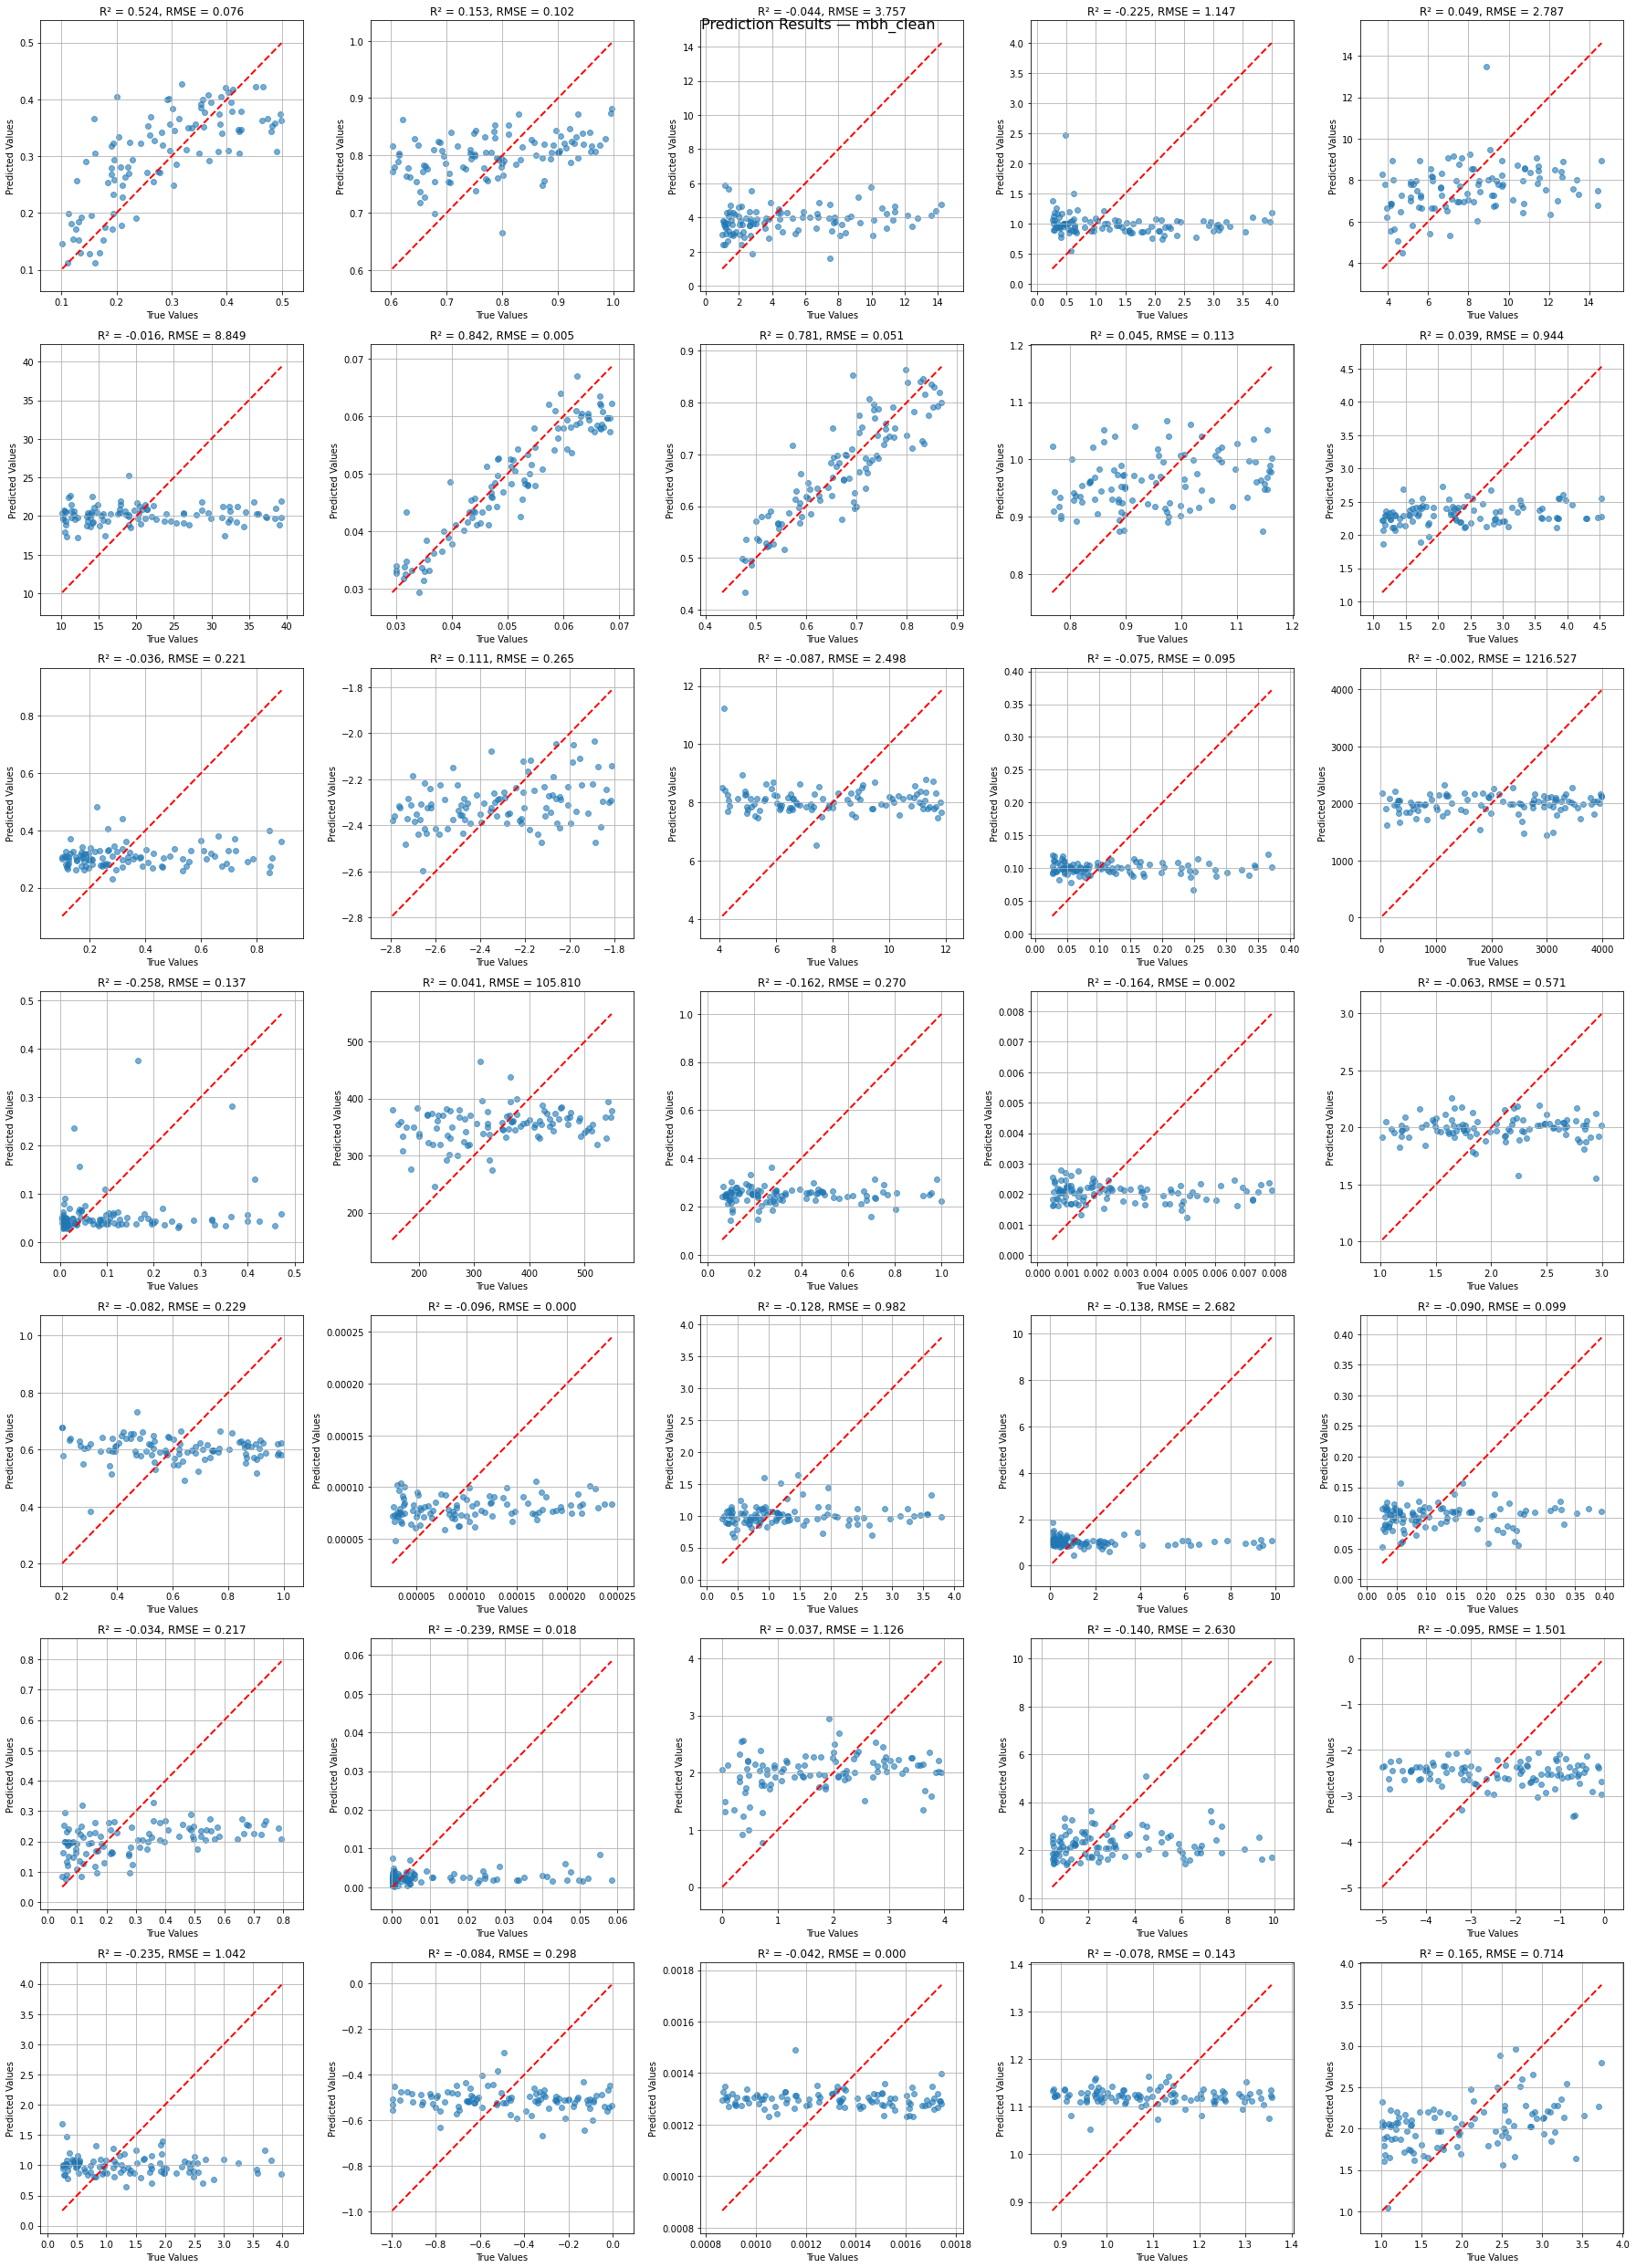

 Case: zs_clean


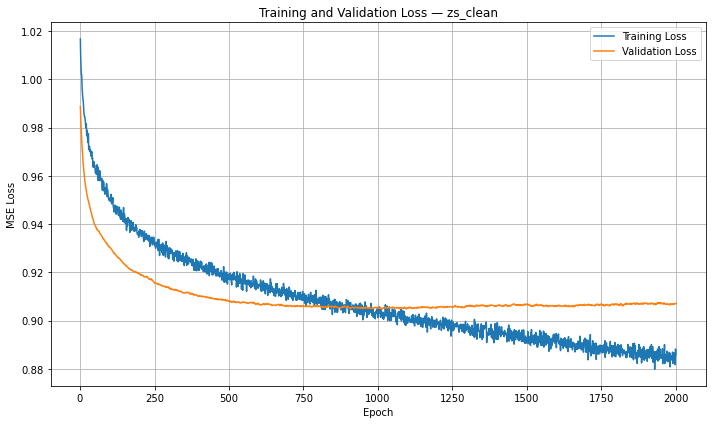

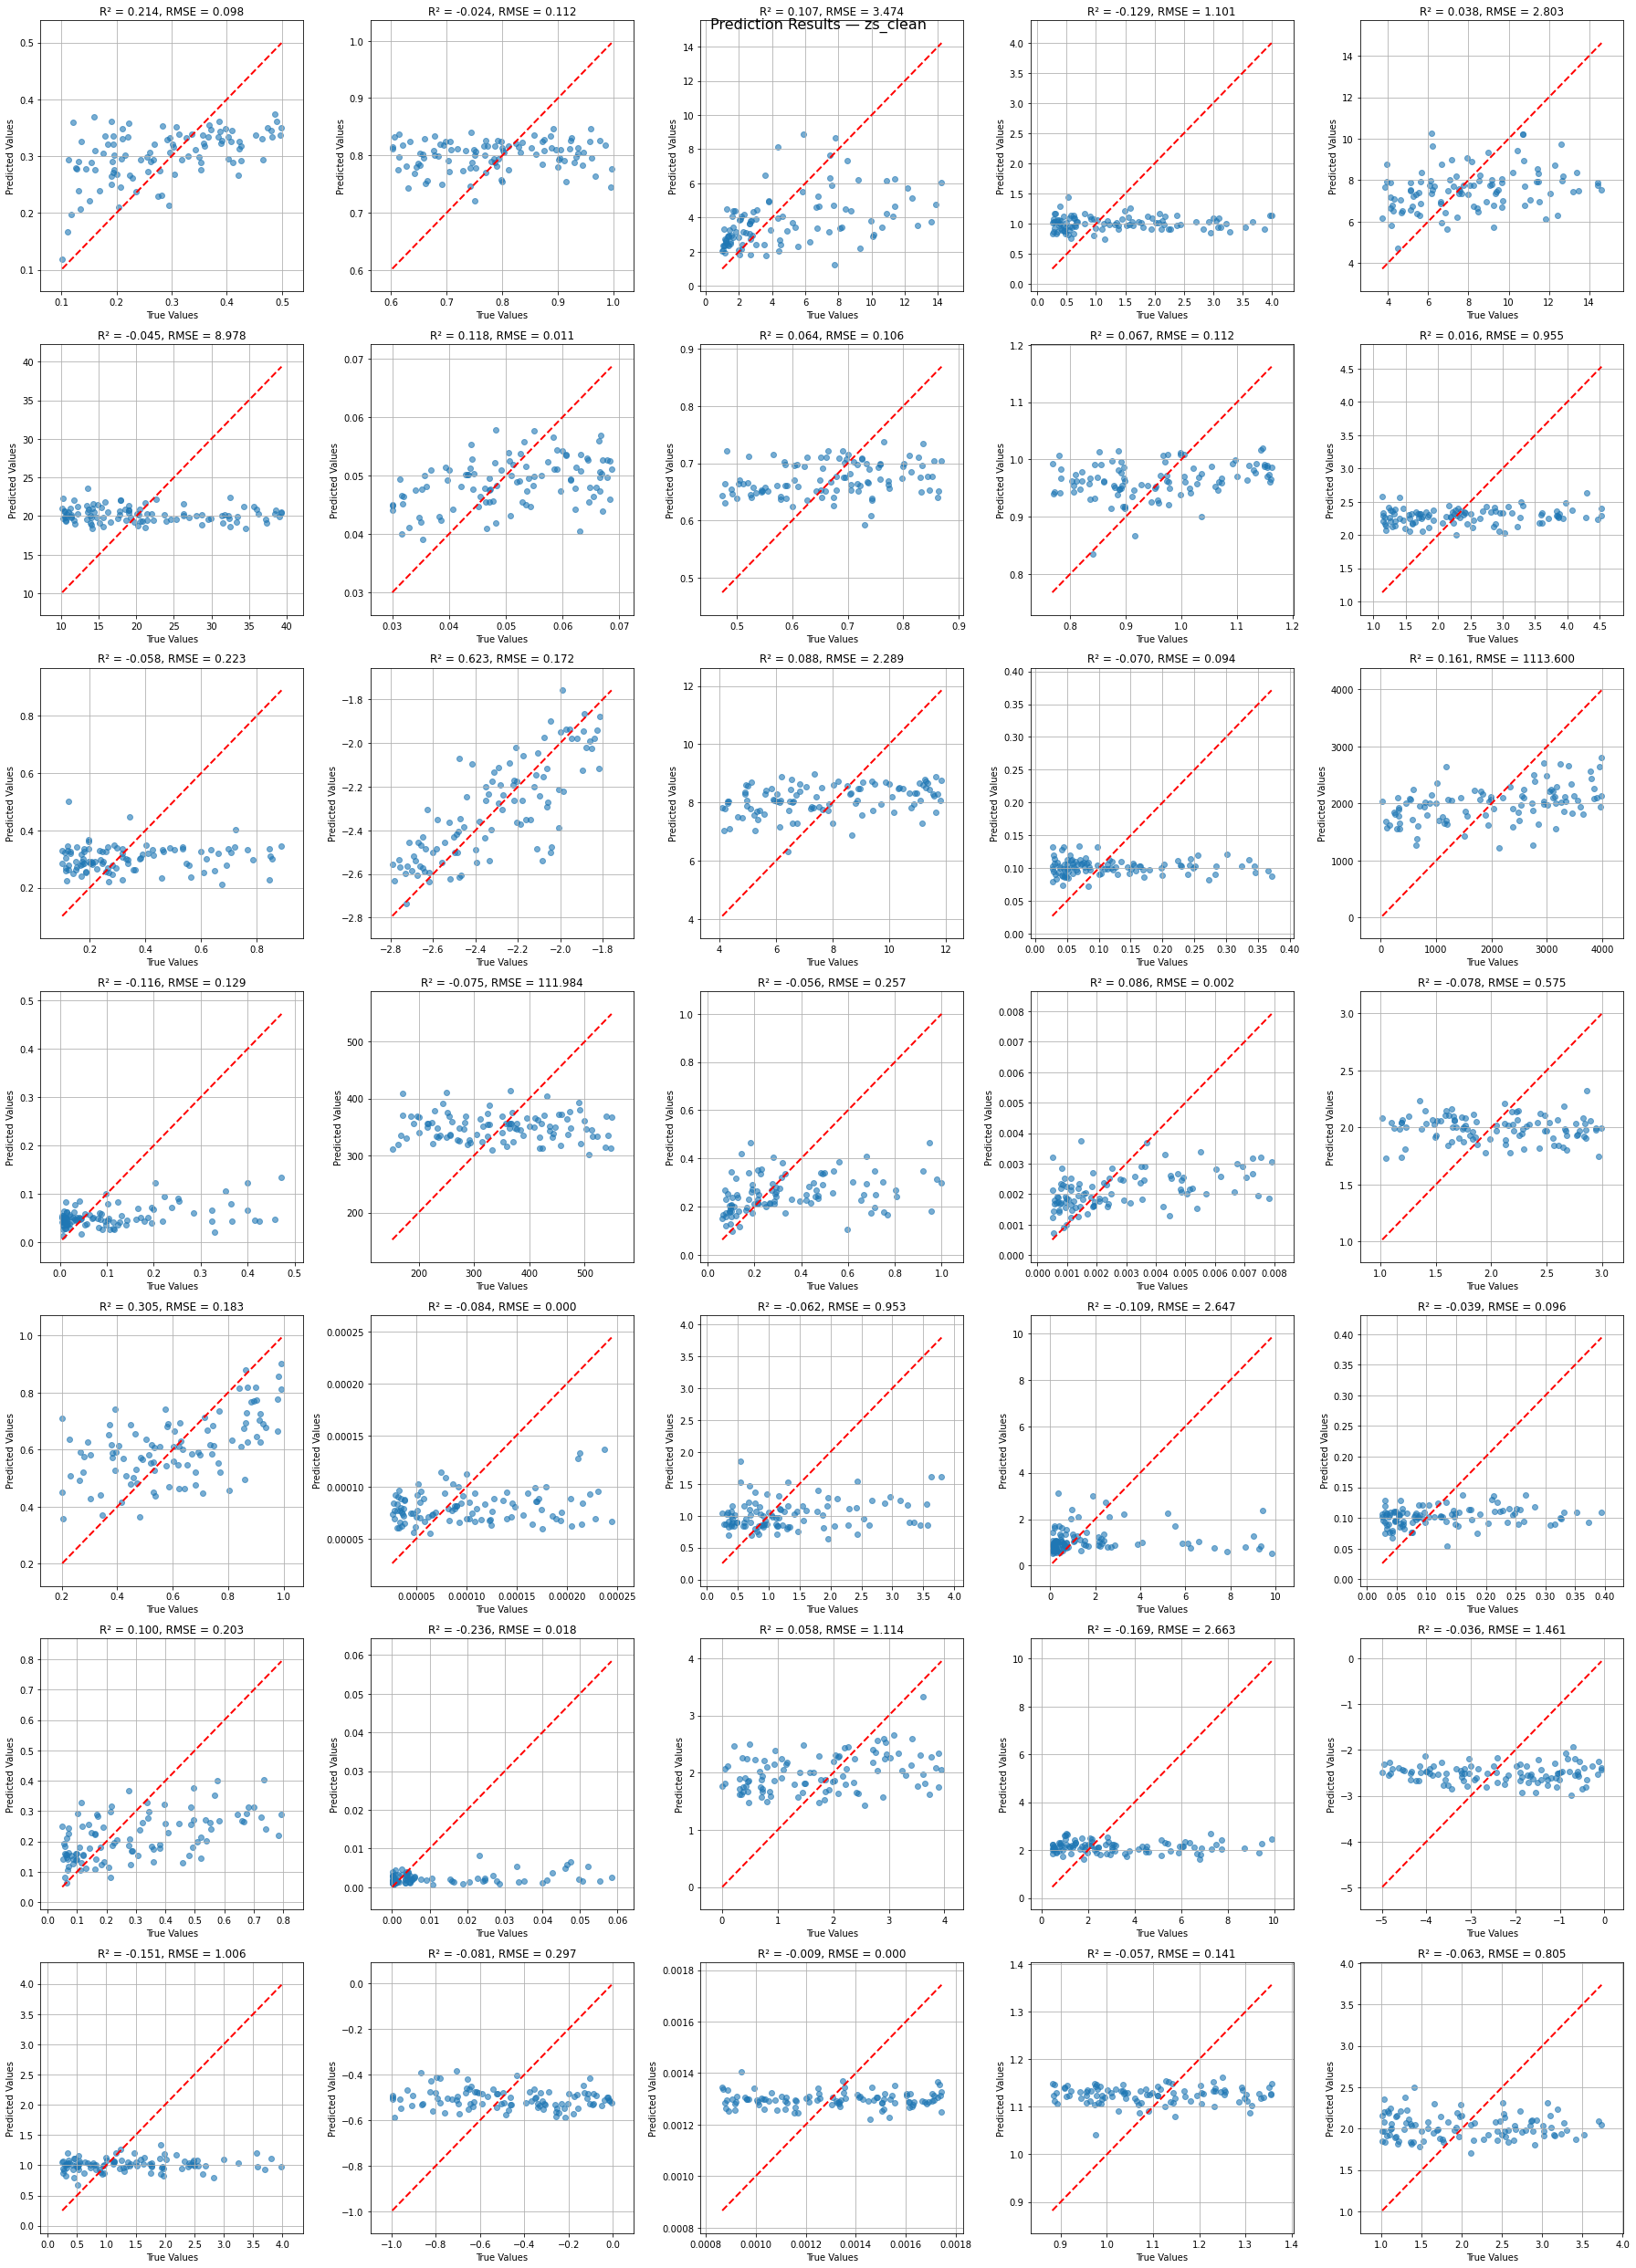

 Case: mbh_noisy


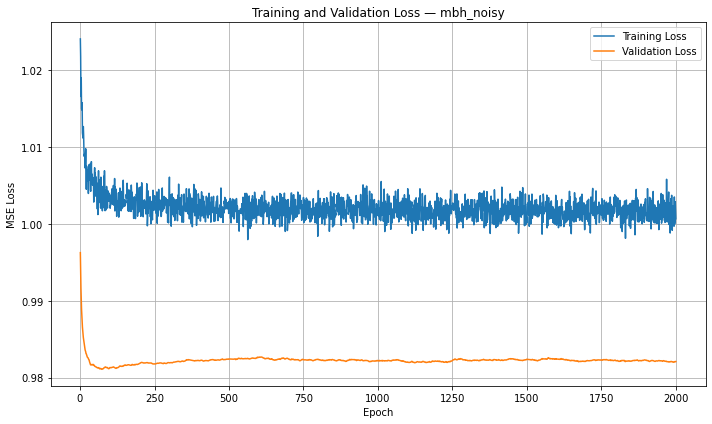

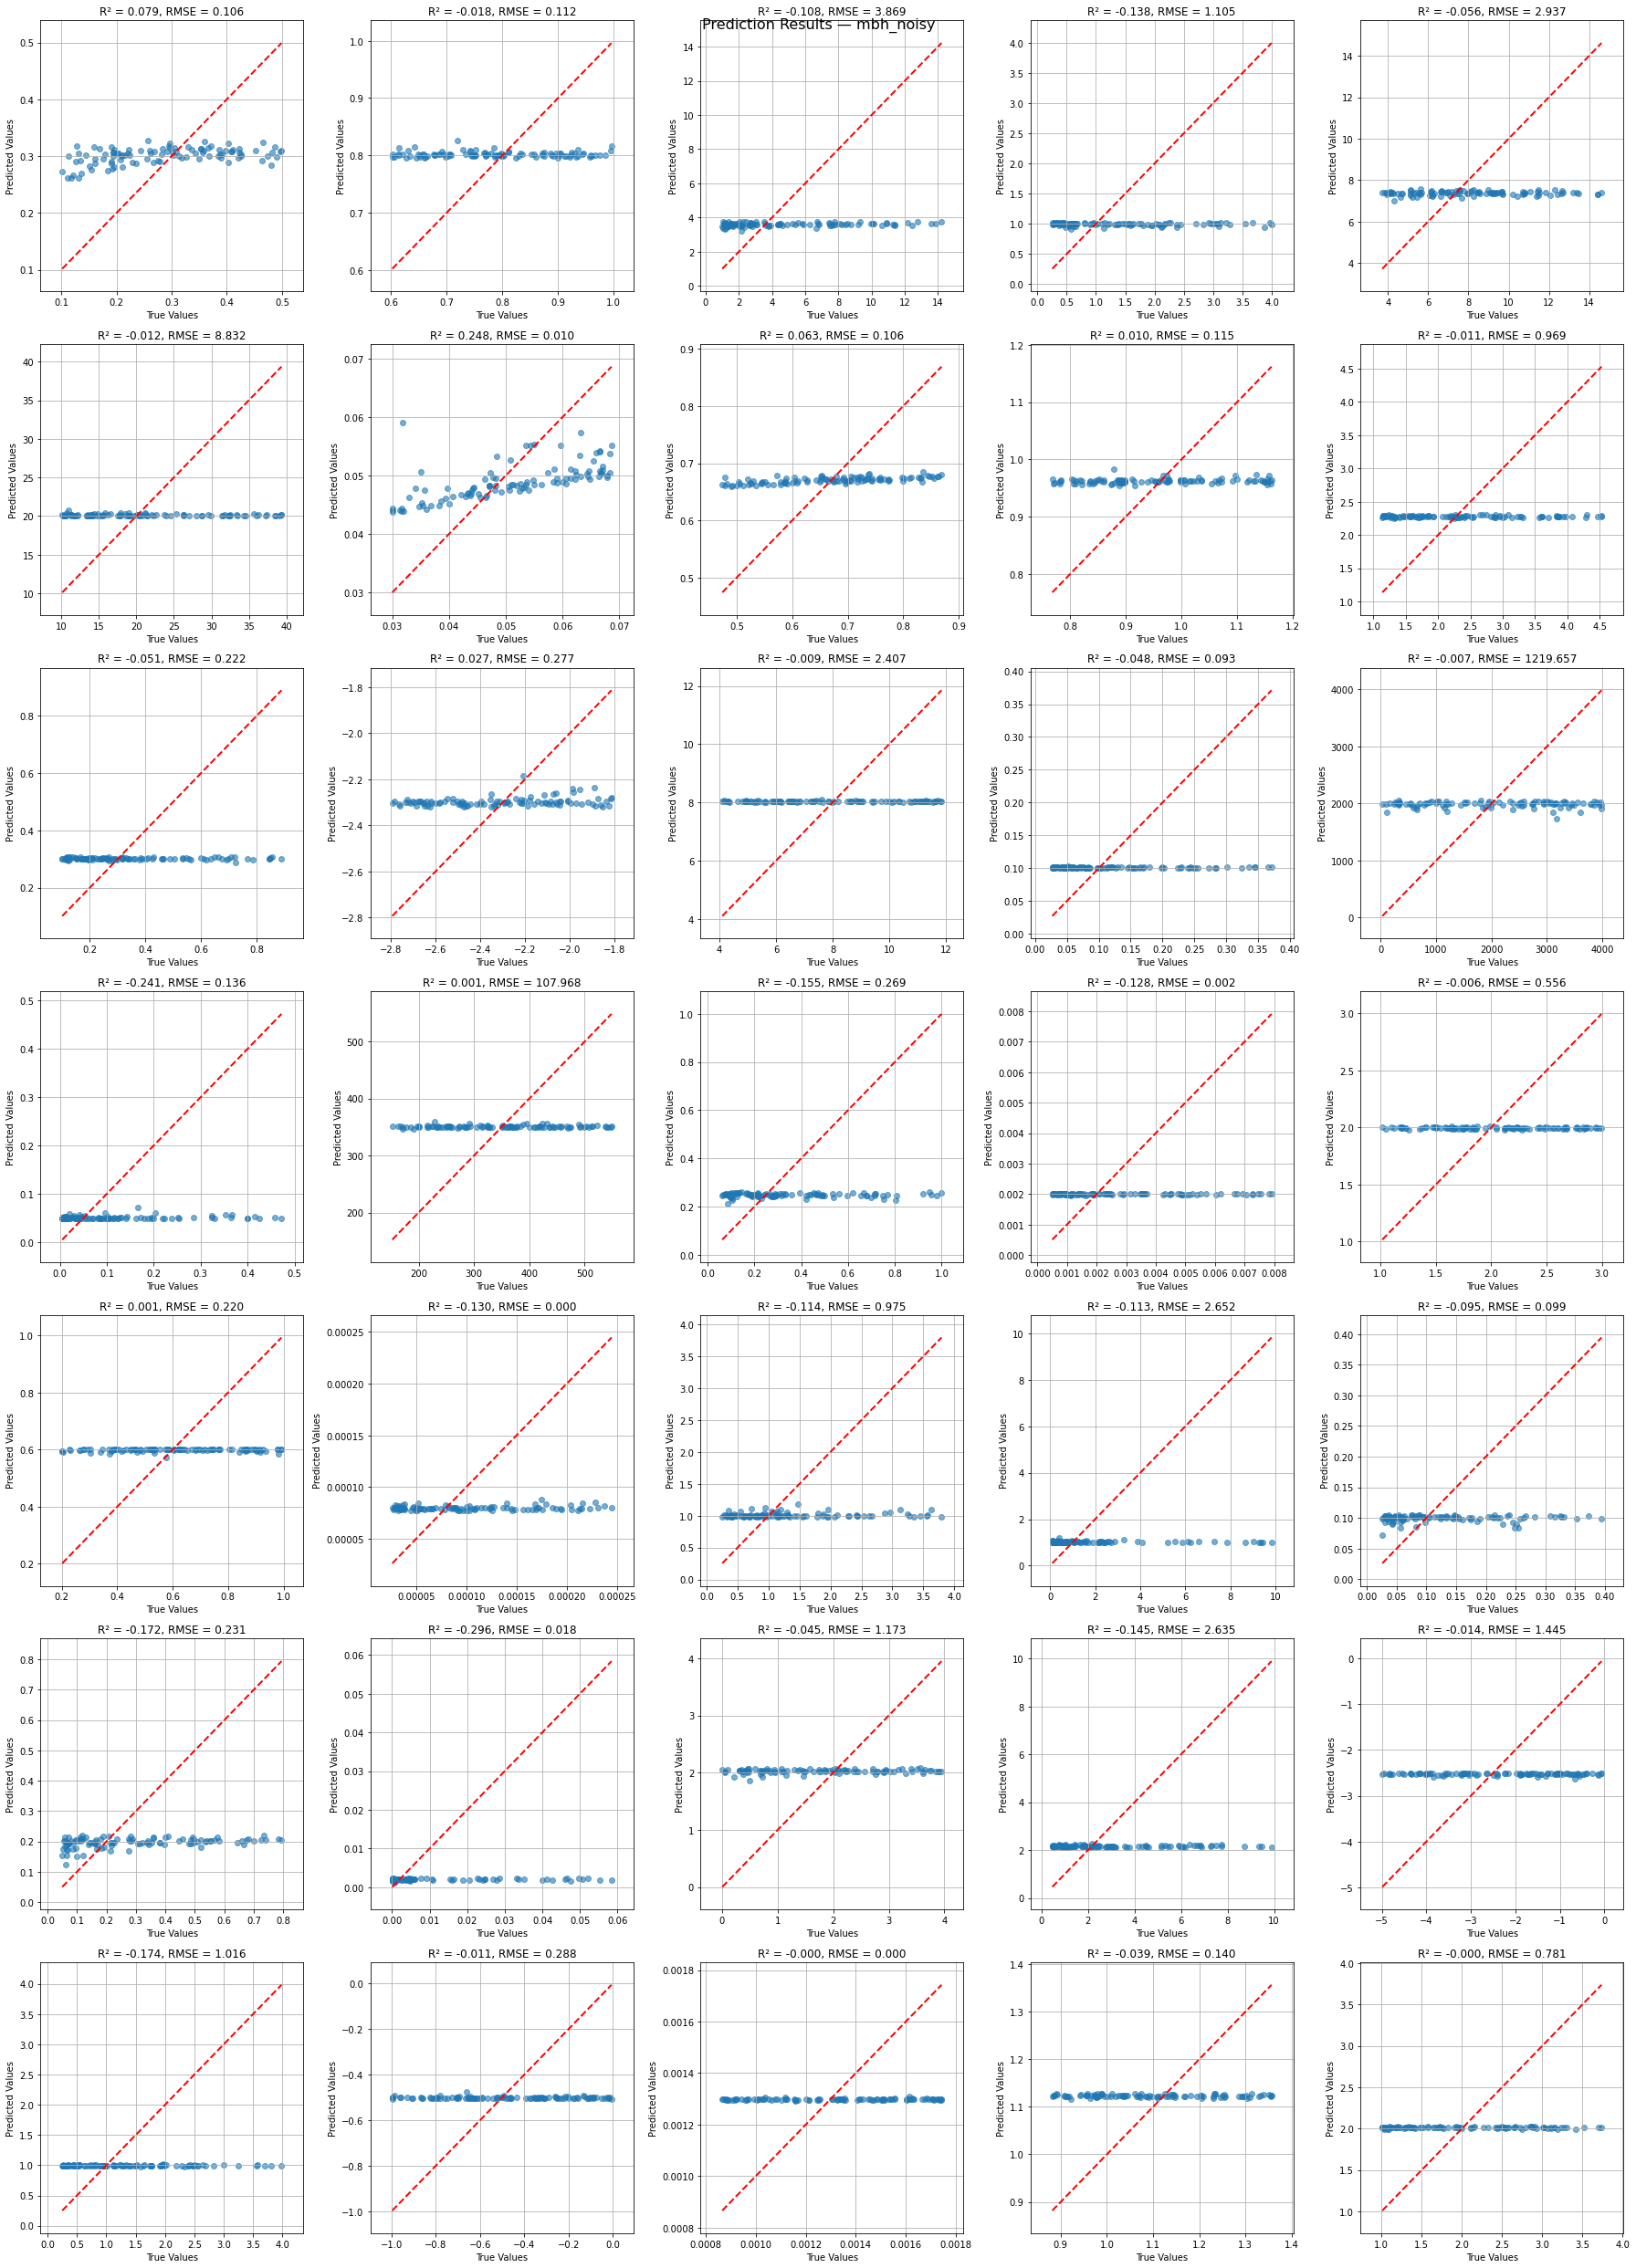

 Case: zs_noisy


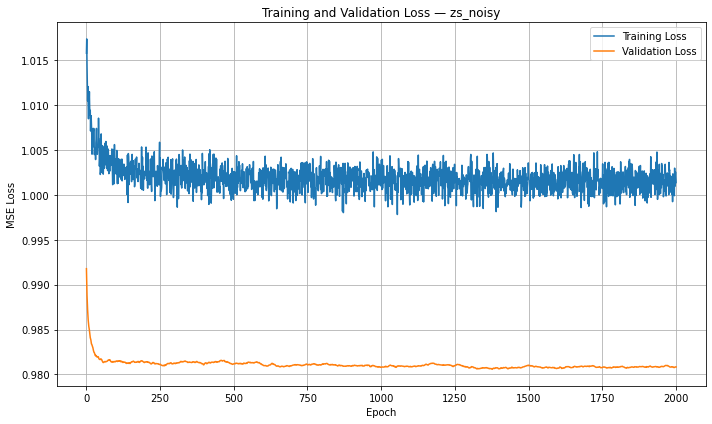

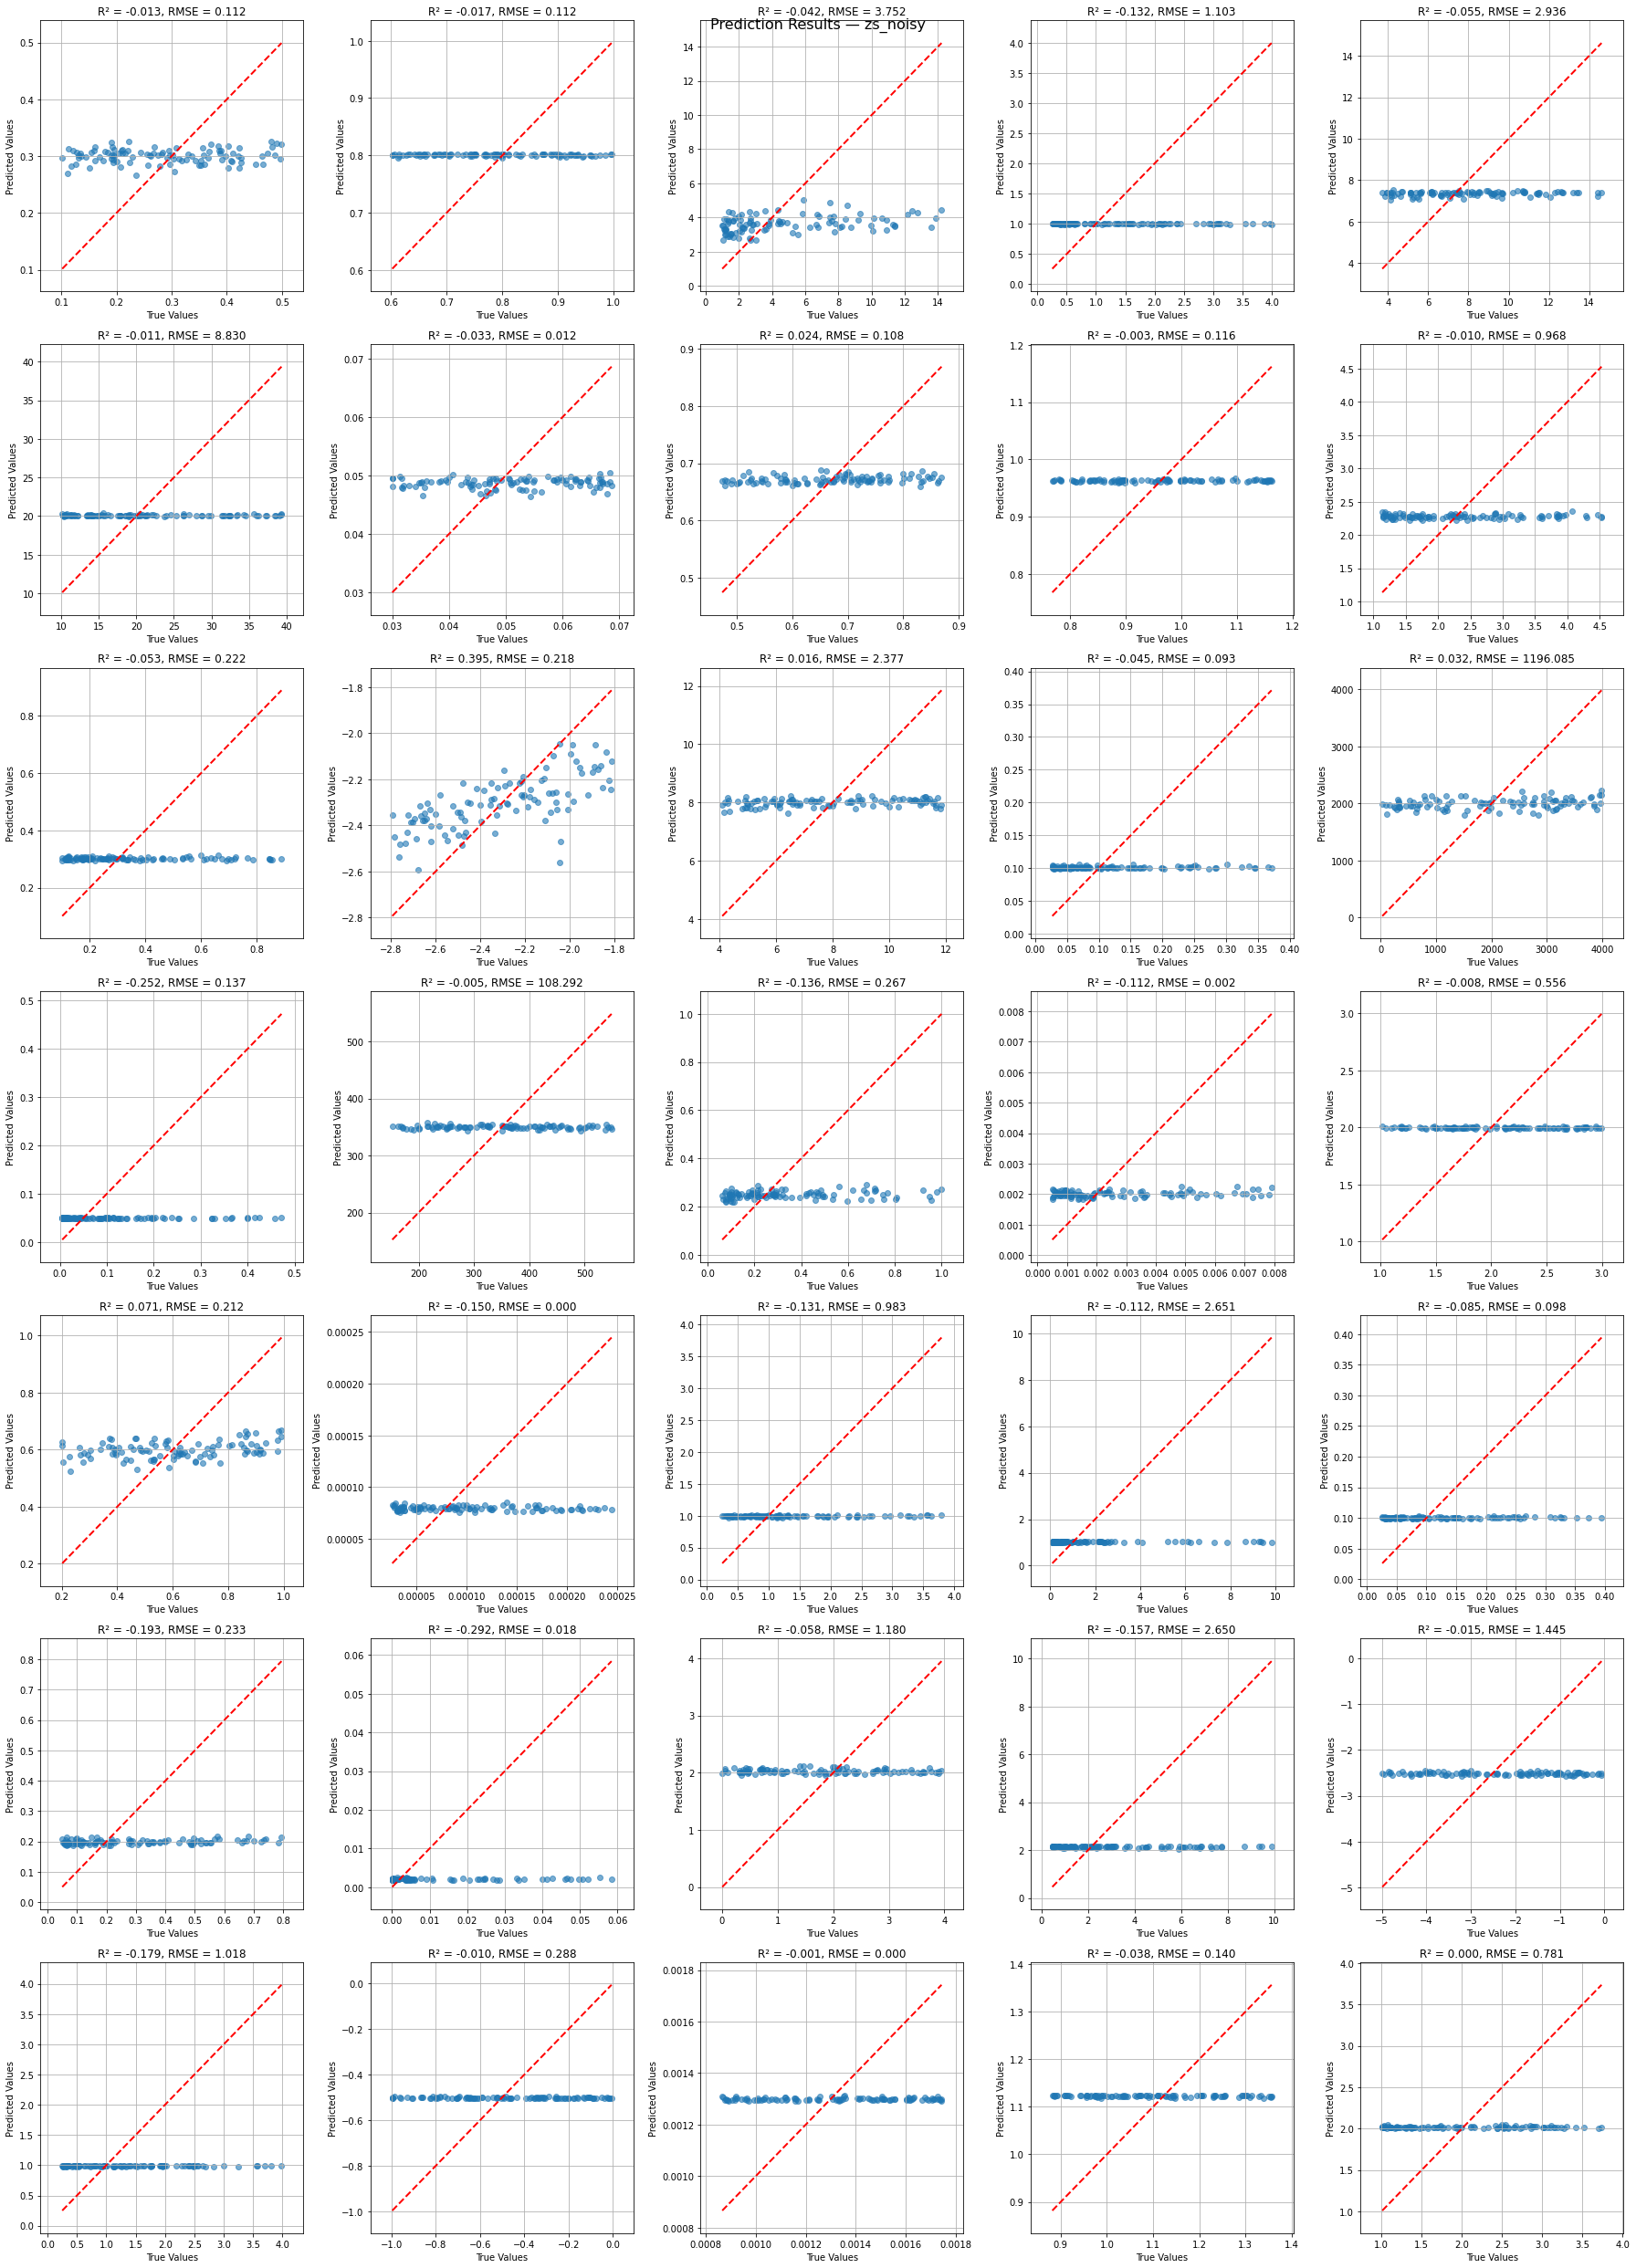

 Case: both_clean


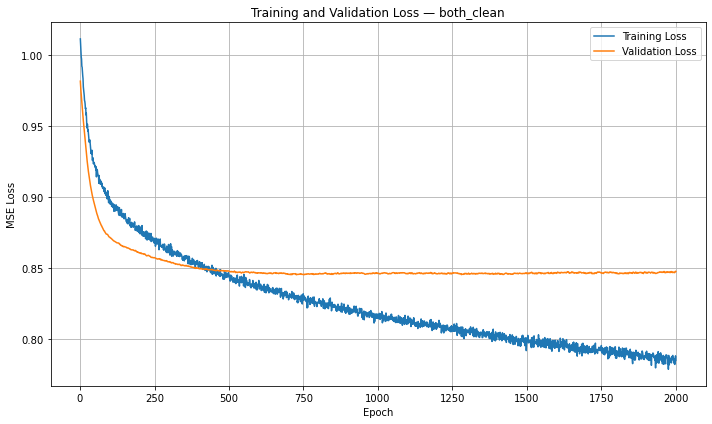

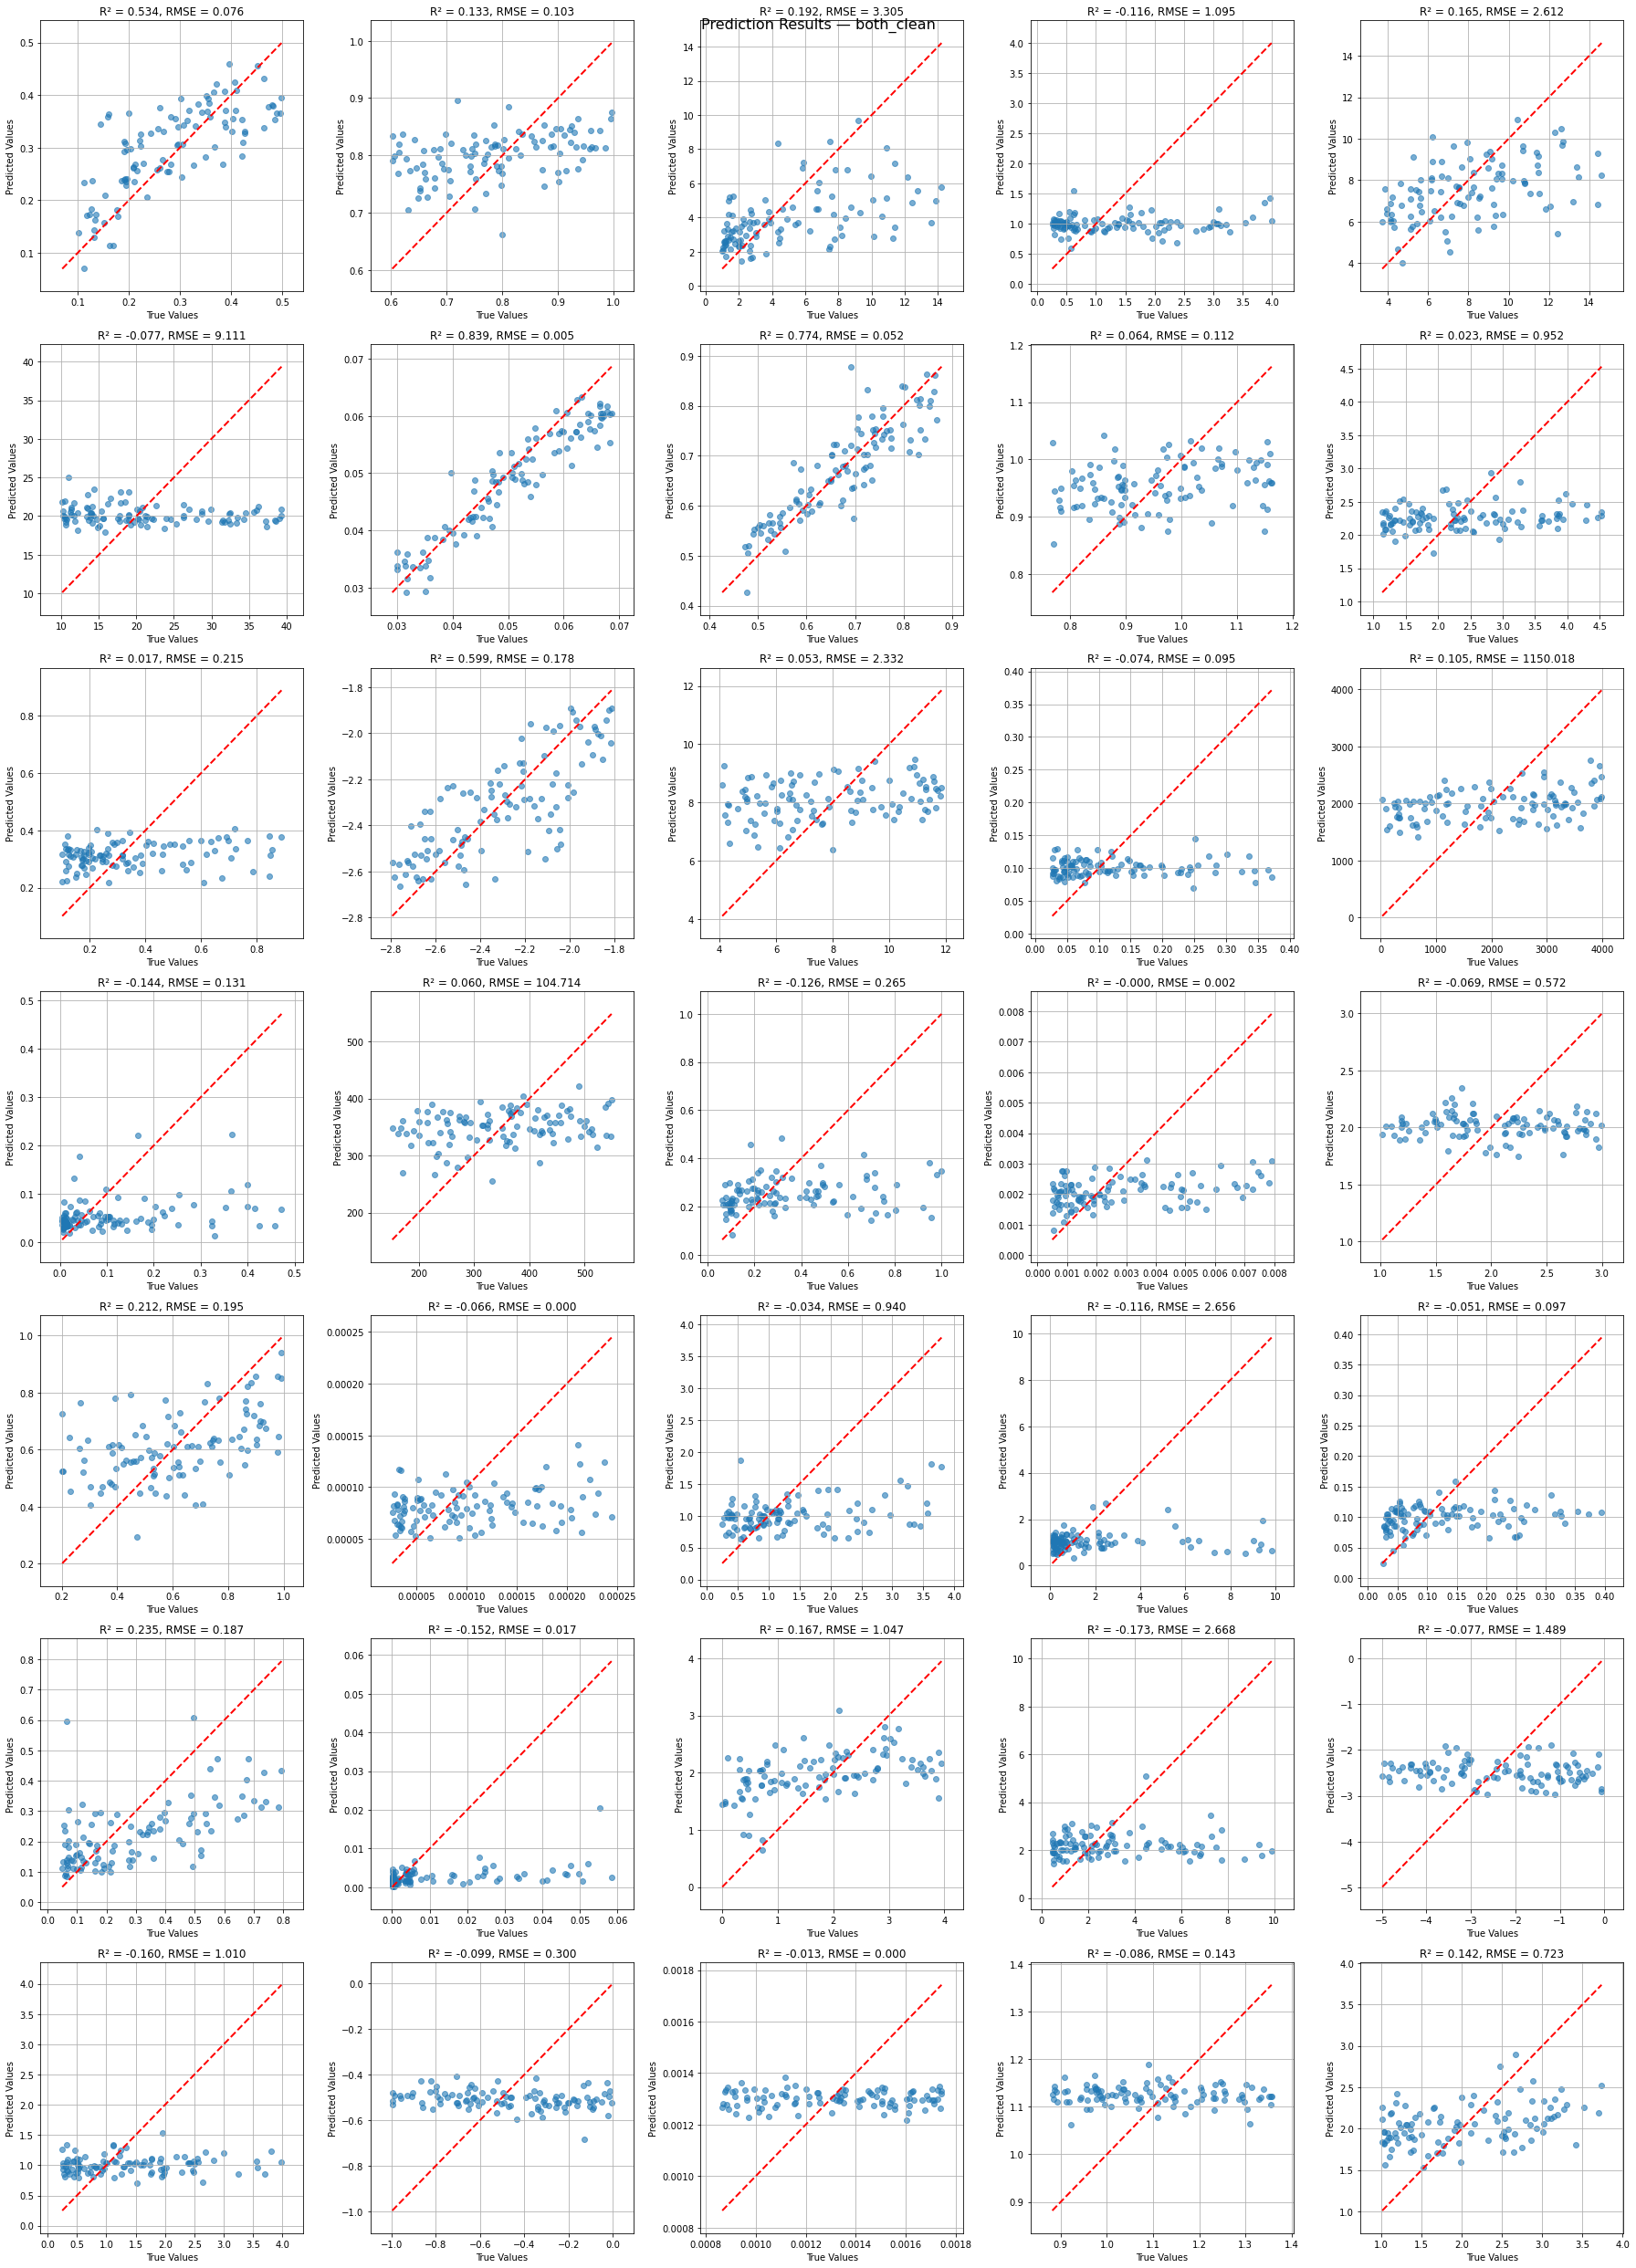

 Case: mbh_noisy_zs_clean


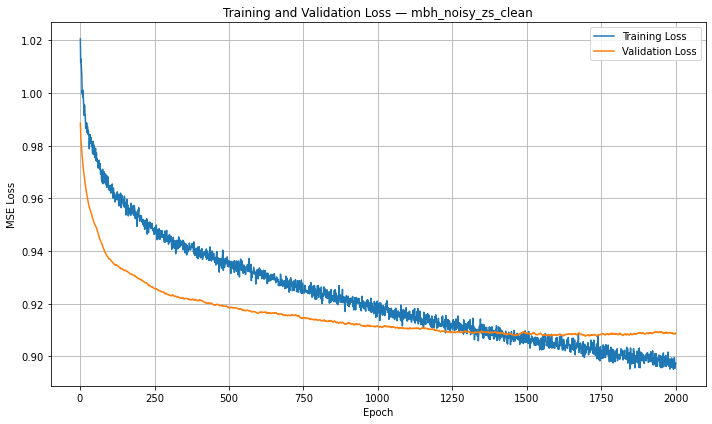

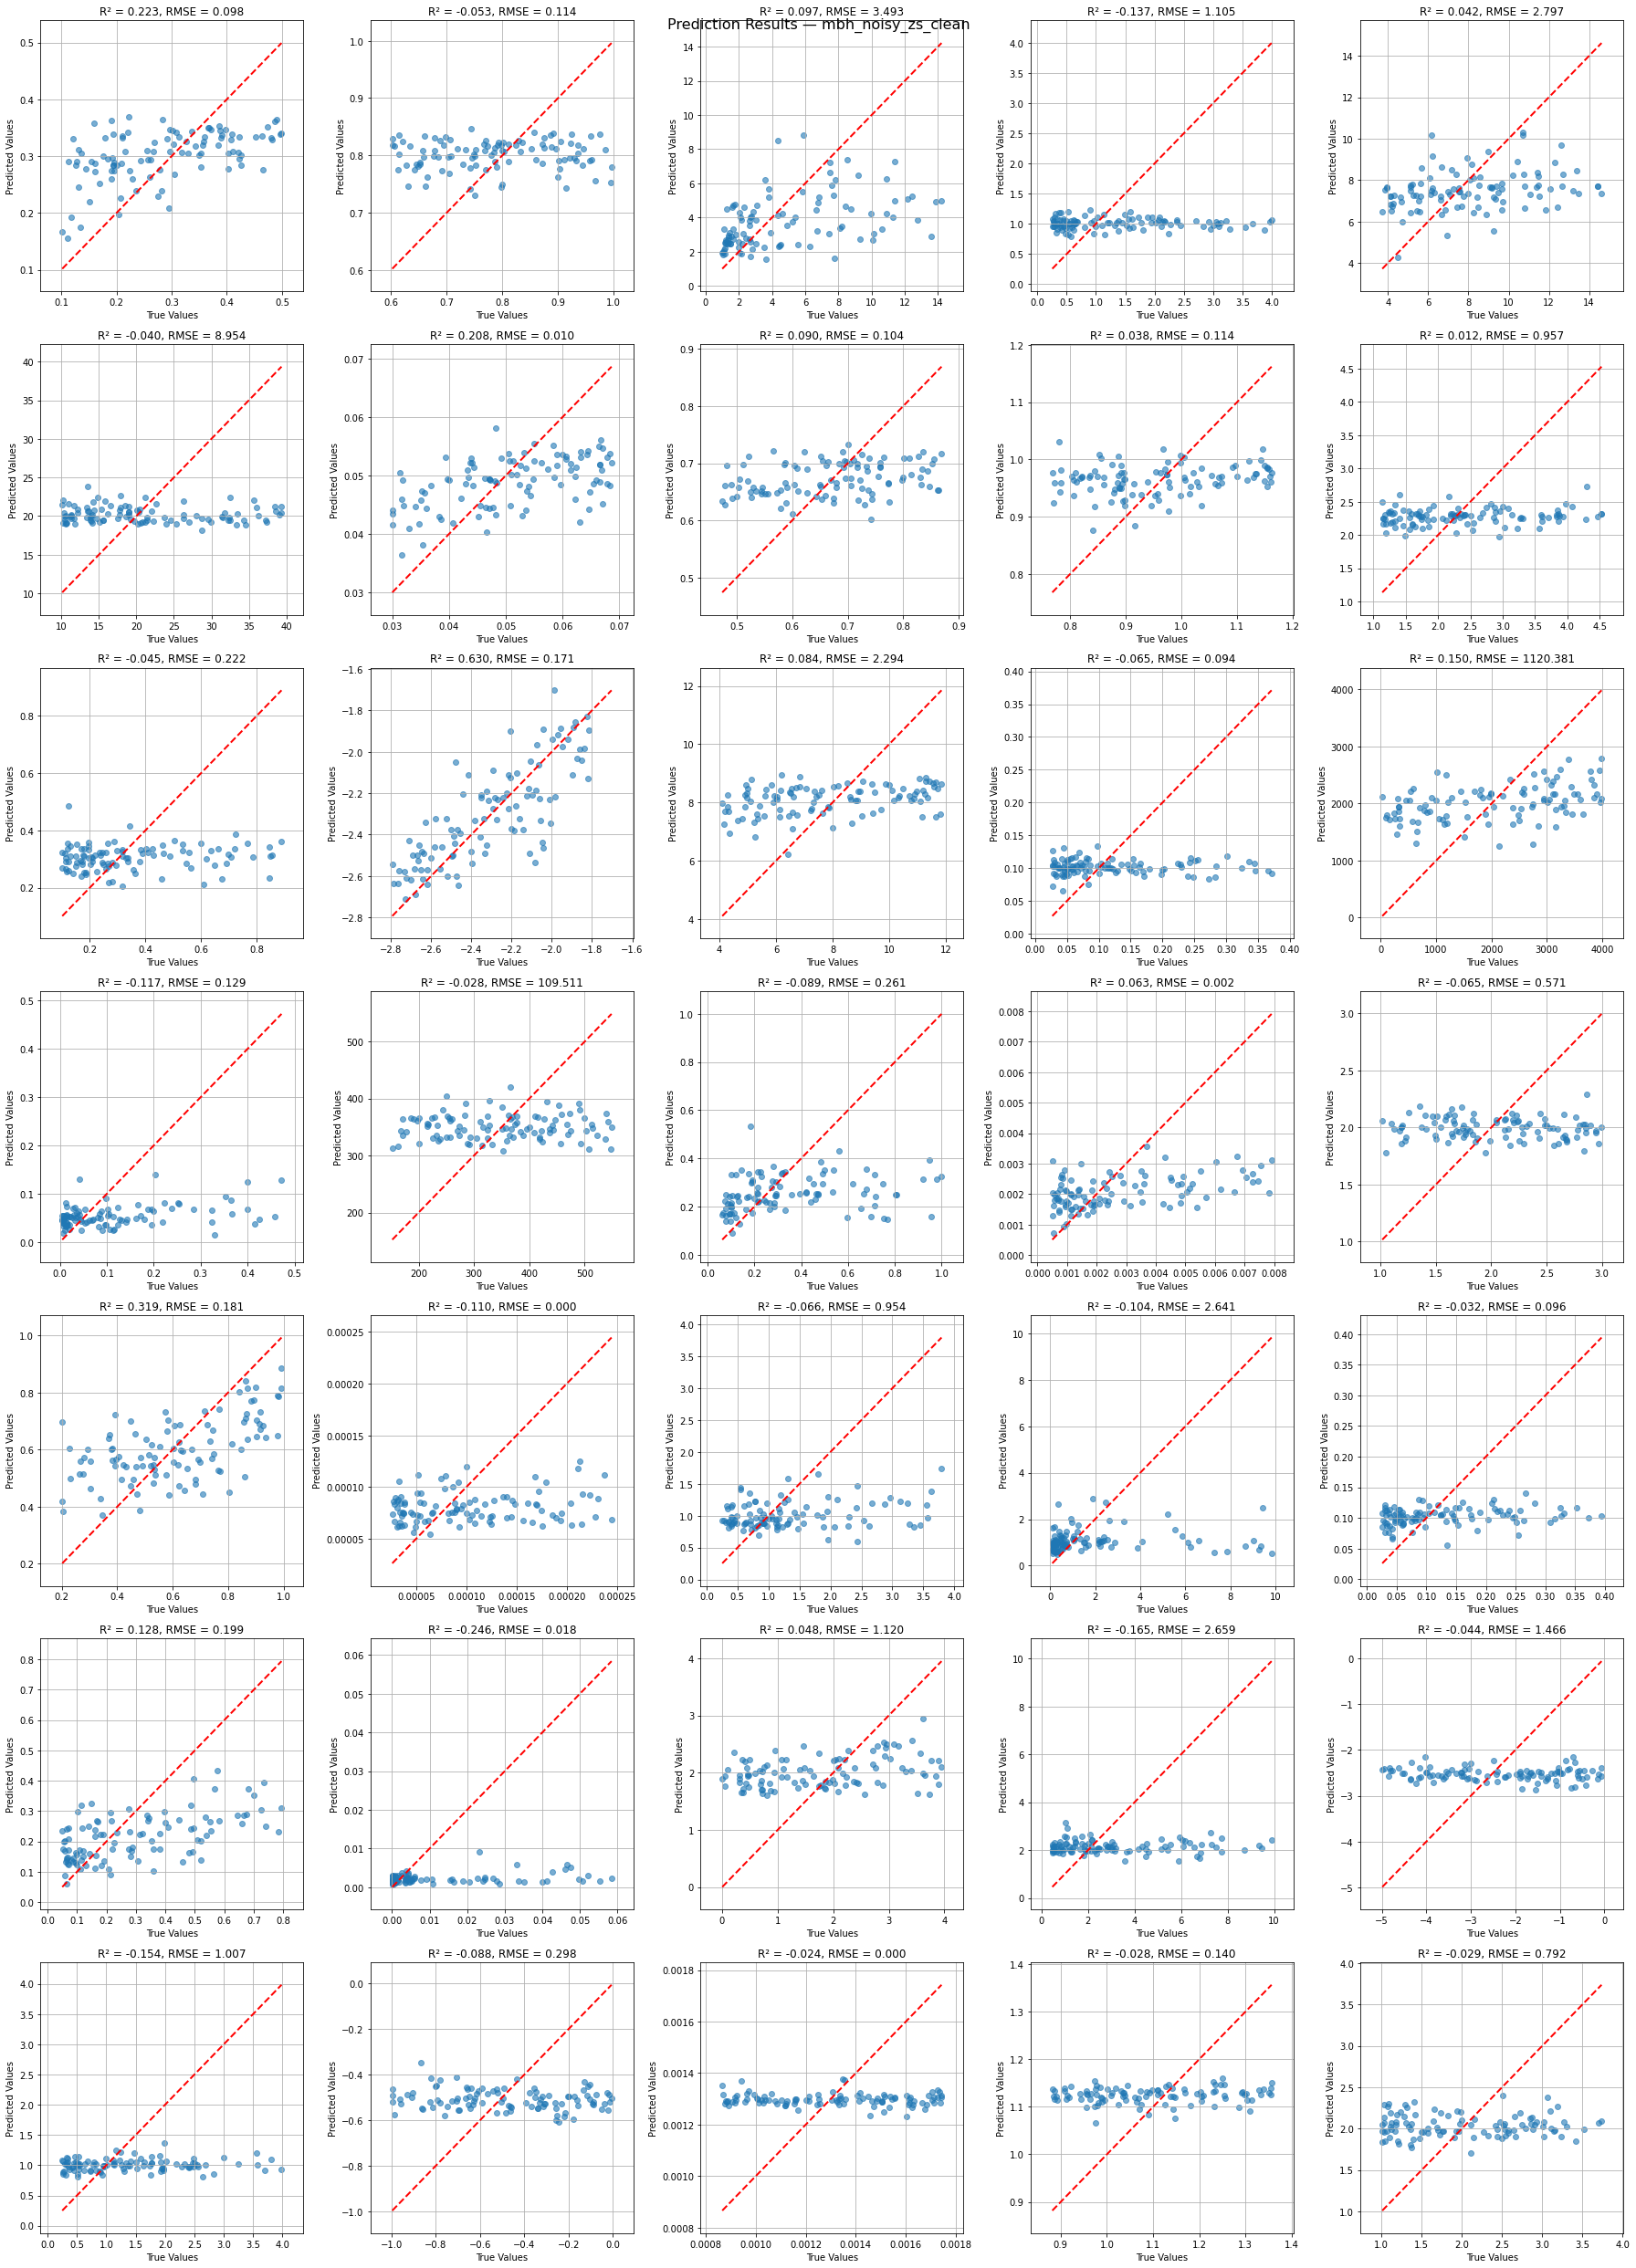

 Case: mbh_clean_zs_noisy


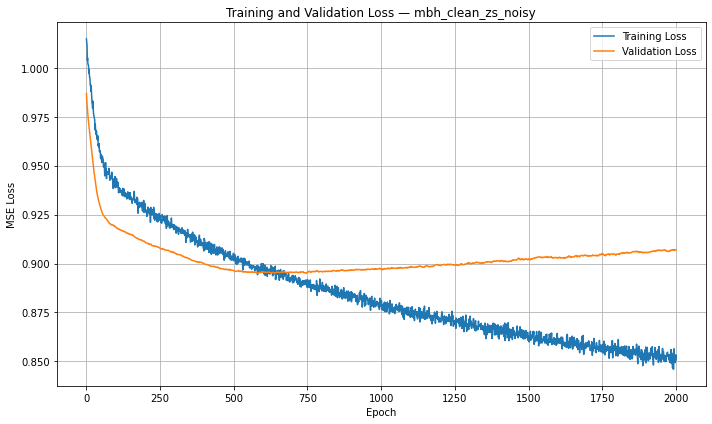

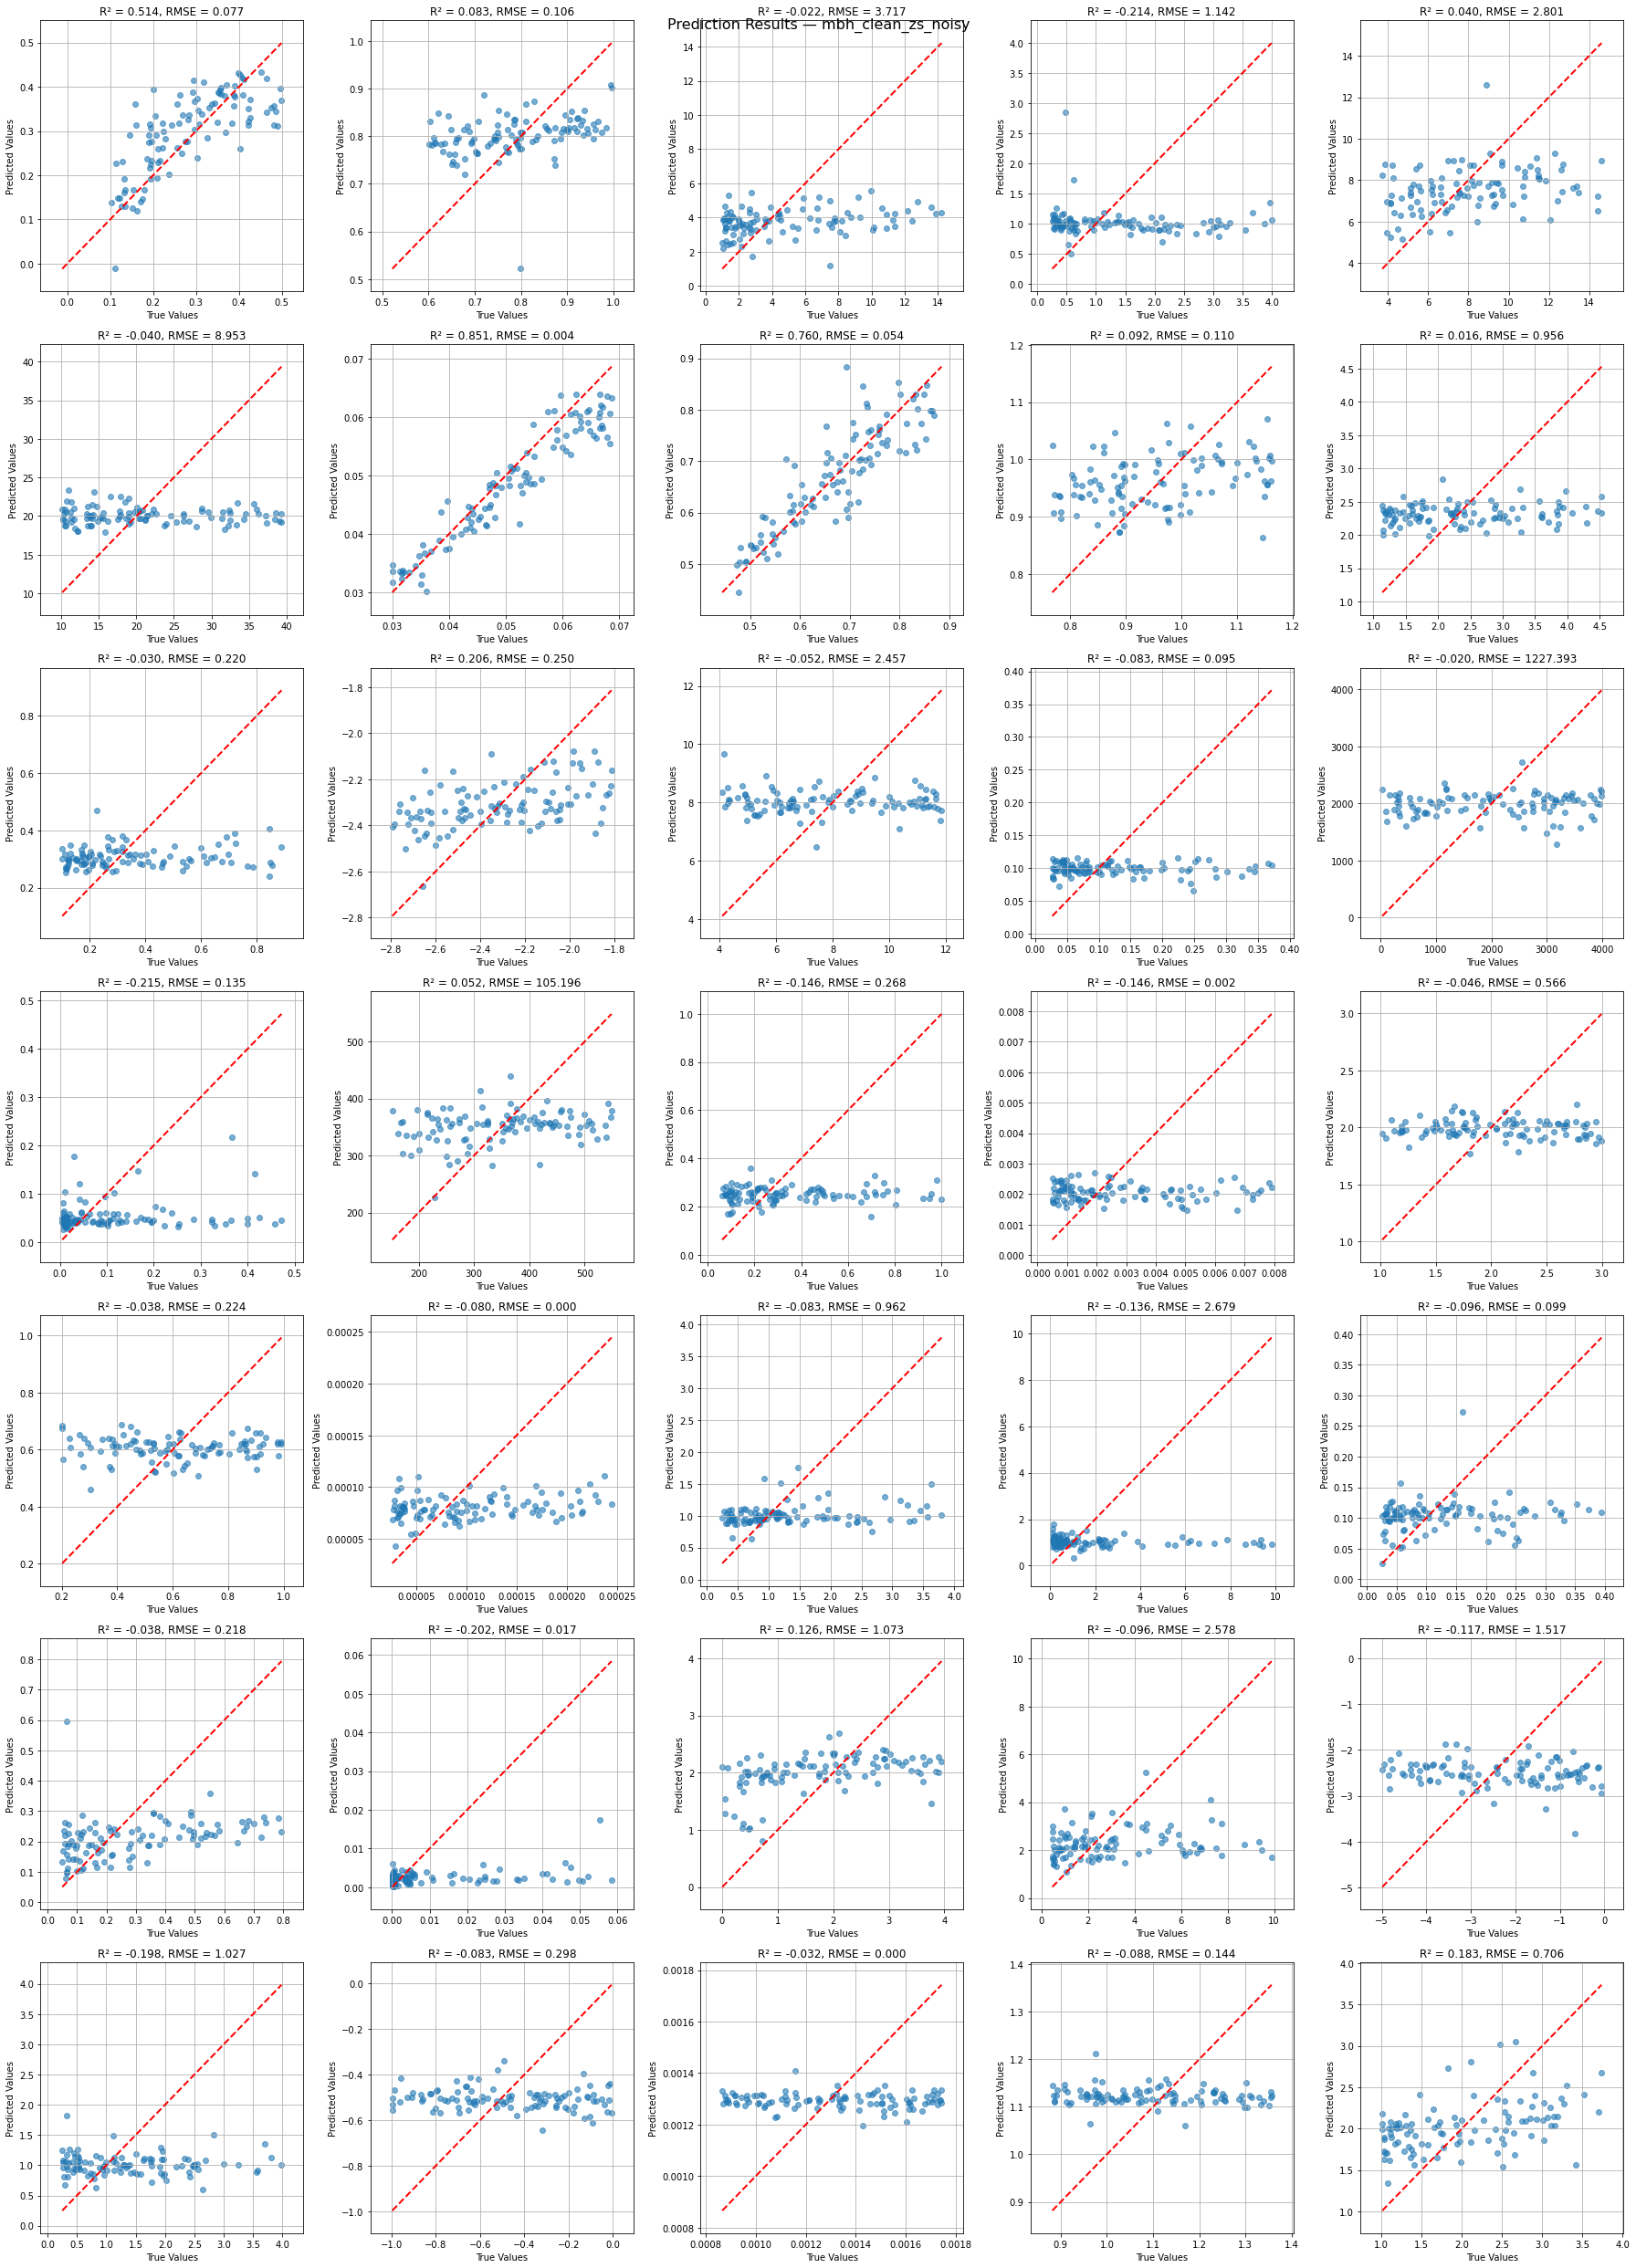

 Case: both_noisy


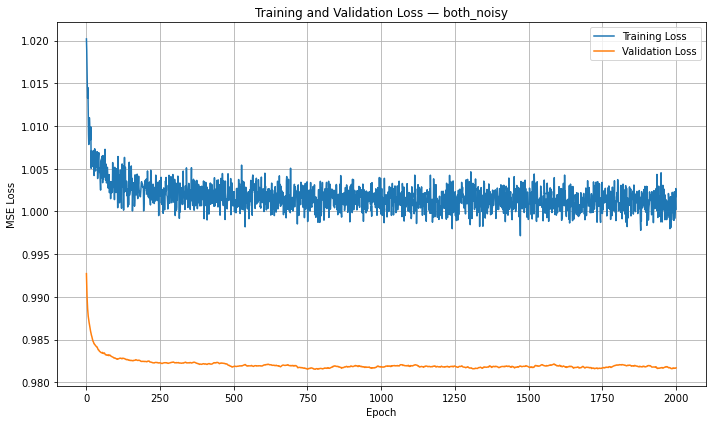

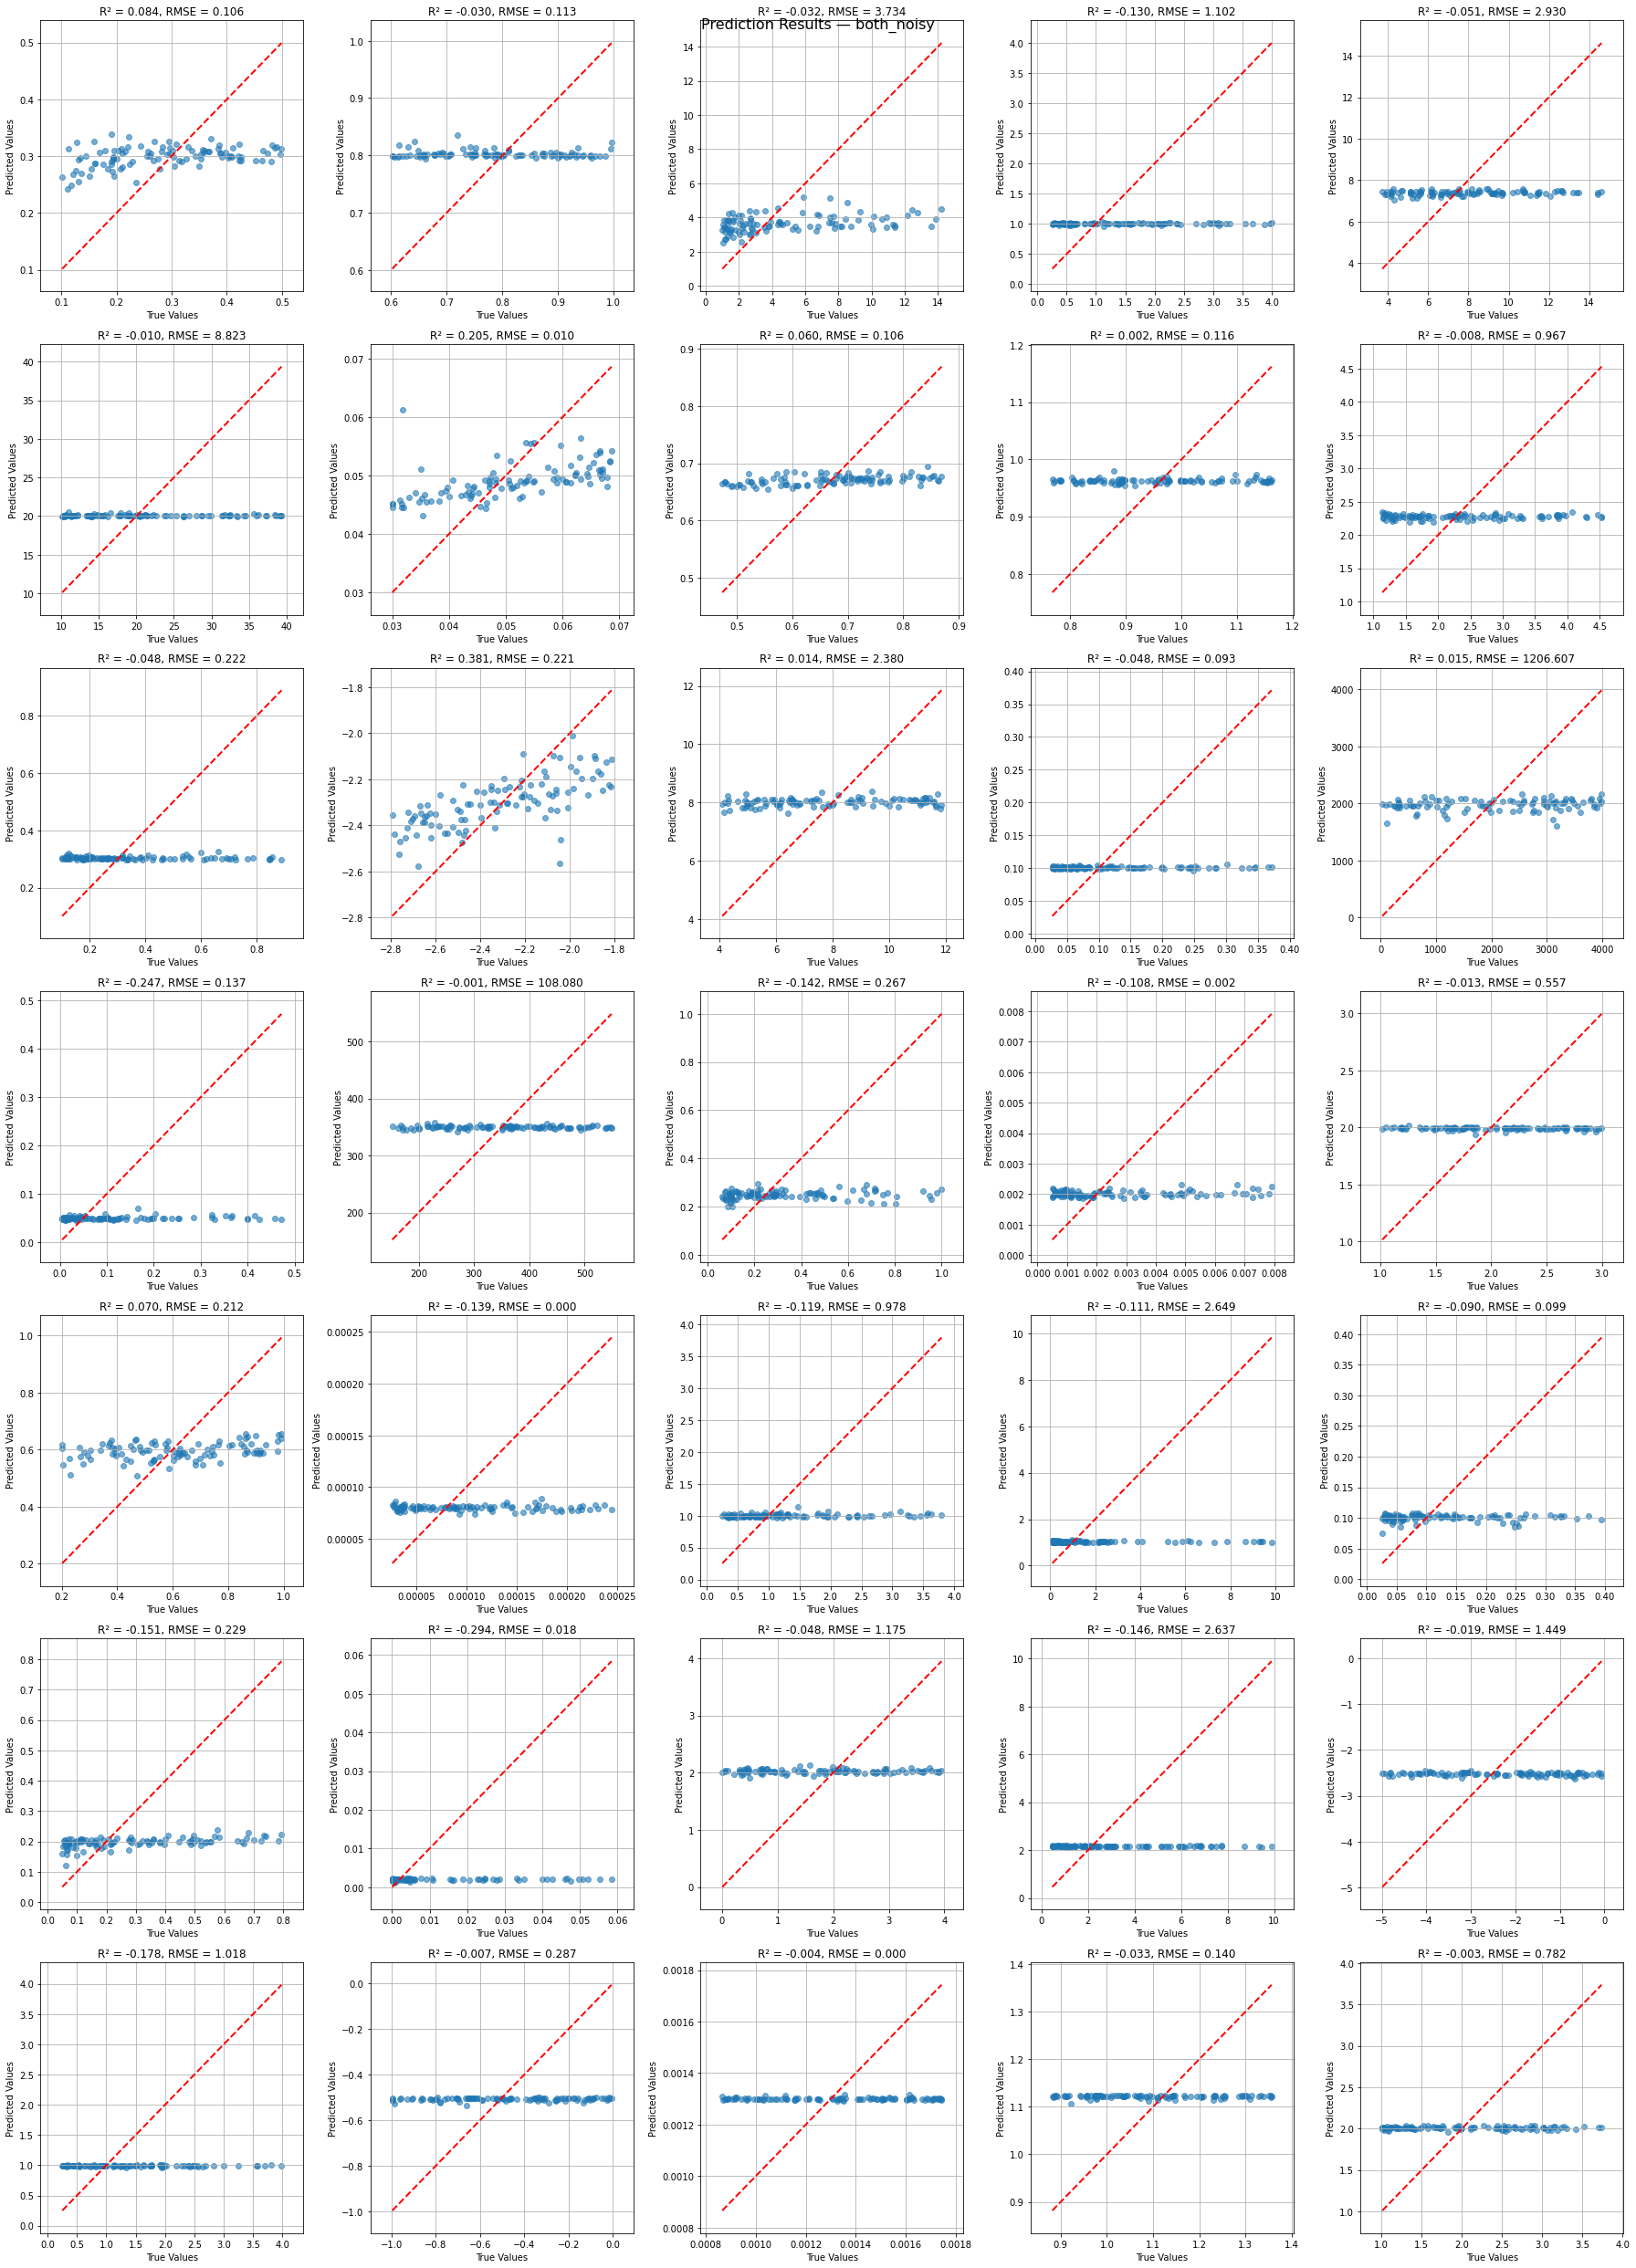

In [19]:
from sklearn.metrics import r2_score, mean_squared_error

r2_matrix = np.zeros((len(all_results),output_dim))

output_dir = os.path.abspath(os.path.join(os.getcwd(), "../../noise_results"))
os.makedirs(output_dir, exist_ok=True)


for result in all_results:
    model = result["model"]
    train_losses = result["train_losses"]
    val_losses = result["val_losses"]
    case_name = result["case_name"]

    print(f" Case: {case_name}")

    # Plot losses
    plt.figure(figsize=(10, 6))
    epochs_range = range(1, len(train_losses) + 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss — {case_name}')
    
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    path = os.path.join(output_dir, f"{case_name}_loss.png")
    plt.savefig(path, dpi=200)
    plt.show()

    model.eval()
    predictions, true_values = [], []

    val_loader_fn = make_loader_fn(
        selected_observables=result["selected_observables"],
        x_raw_dict=x_raw_dict,
        y_vector=y,
        idx=idx_val,
        batch_size=batch_size,
        noise_override=0.0  
    )
    val_loader = val_loader_fn()

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            predictions.append(preds.cpu())
            true_values.append(yb.cpu())

    all_predictions = torch.cat(predictions).numpy()
    all_true_values = torch.cat(true_values).numpy()

    # Undo normalization if needed
    all_predictions = all_predictions * stds + means
    all_true_values = all_true_values * stds + means
    all_predictions[:, logflag] = np.exp(all_predictions[:, logflag])
    all_true_values[:, logflag] = np.exp(all_true_values[:, logflag])

    # Generate prediction vs true scatter plots
    n_cols = int(np.floor(np.sqrt(output_dim)))
    n_rows = int(np.ceil(output_dim / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)

    for i in range(output_dim):
        ax = axes.flat[i]
        preds_i = all_predictions[:, i]
        trues_i = all_true_values[:, i]
        ax.scatter(trues_i, preds_i, alpha=0.6)
        r2 = r2_score(trues_i, preds_i)
        rmse = np.sqrt(mean_squared_error(trues_i, preds_i))

        #save r2 for summary statistics
        r2_matrix[all_results.index(result), i] = r2
        
        min_val = min(trues_i.min(), preds_i.min())
        max_val = max(trues_i.max(), preds_i.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'R² = {r2:.3f}, RMSE = {rmse:.3f}')
        ax.grid(True)
        span = max_val - min_val
        ax.set_xlim(min_val - 0.1 * span, max_val + 0.1 * span)
        ax.set_ylim(min_val - 0.1 * span, max_val + 0.1 * span)

    # Remove empty subplots
    for j in range(output_dim, n_rows * n_cols):
        fig.delaxes(axes.flat[j])

    fig.suptitle(f"Prediction Results — {case_name}", fontsize=16)
    fig.tight_layout()
    save_path = os.path.join(output_dir, f"{case_name}_predictions.png")
    plt.savefig(save_path, dpi=200)
    plt.show()


In [20]:
len(all_results[3])

5

In [21]:
for result in all_results:
    print(all_results.index(result))

0
1
2
3
4
5
6
7


In [22]:
print(noise_cases.keys())

dict_keys(['mbh_clean', 'zs_clean', 'mbh_noisy', 'zs_noisy', 'both_clean', 'mbh_noisy_zs_clean', 'mbh_clean_zs_noisy', 'both_noisy'])


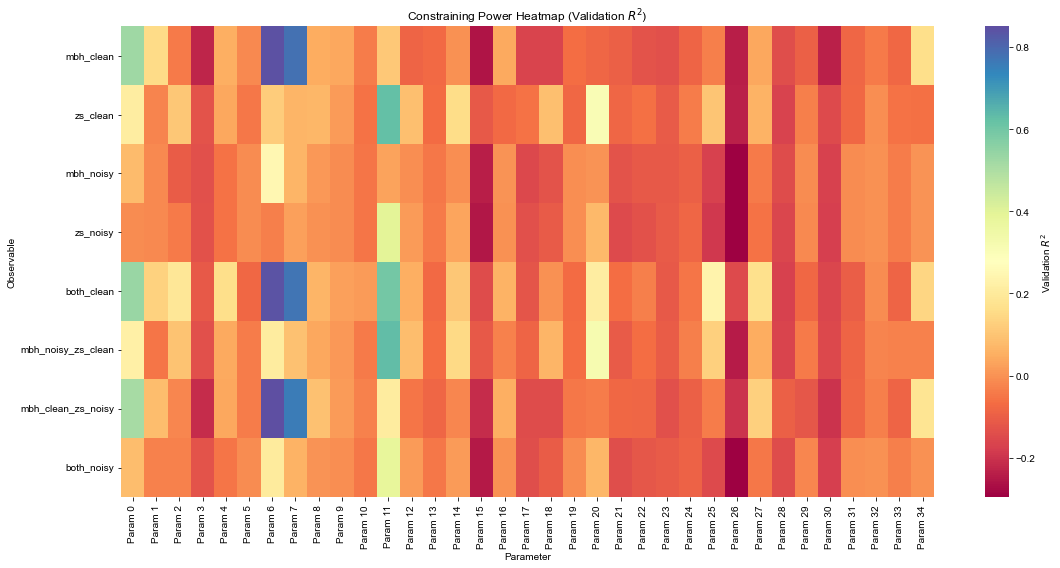

In [23]:
# Create a DataFrame for nicer labels (optional)

import pandas as pd
import seaborn as sns


r2_df = pd.DataFrame(
    r2_matrix,
    index=[f"{i}" for i in noise_cases.keys()],
    columns=[f"Param {j}" for j in range(r2_matrix.shape[1])]
)

plt.figure(figsize=(16, 8))
sns.heatmap(
    r2_df,
    cmap = 'Spectral',
    annot=False,
    fmt=".2e",
    cbar_kws={'label': 'Validation $R^{2}$'}
)
sns.set_style("white")

plt.title(f"Constraining Power Heatmap (Validation $R^{2}$)")
plt.ylabel("Observable")
plt.xlabel("Parameter")
plt.tight_layout()
plt.savefig("../../noise_results/zs_mbh_r2.png", dpi=200)
plt.show()